# Counterfactual Analysis of Target Temperature Management (TTM) Protocols

## Introduction
This notebook explores the impact of different Target Temperature Management (TTM) protocols on patient outcomes, aiming to identify optimal treatments for specific patient subpopulations. By evaluating counterfactual scenarios, we assess how changes in TTM protocols—specifically, TTM at 33°C, TTM at 36°C, and no TTM—affect the model's predictions for each patient. The analysis integrates insights from both Neural Network and XGBoost models to provide a robust understanding of protocol impacts.

Through this notebook, we aim to:
- Simulate counterfactual scenarios and determine the best predicted outcome for each patient under different TTM protocols.
- Identify consensus between models on the optimal protocol for each patient and analyze the characteristics of patients undergoing protocol changes.
- Leverage descriptive analytics, SHAP analysis, and decision trees to explain model decisions and uncover interpretable patterns in protocol changes.

## Table of Contents
1. [Setup & Imports](#setup-imports)
2. [Data Loading and Preparation](#data-loading-preparation)
3. [Define Counterfactual Scenarios and Perform Predictions](#define-scenarios-predict)
4. [Analyze Counterfactual Predictions](#analyze-counterfactual-predictions)
5. [Let Them Vote](#let-them-vote)
6. [Analyze the Consensus-Based Decision](#analyze-consensus)
   1. [Descriptive Analytics](#descriptive-analytics)
   2. [SHAP Analysis](#shap-analysis)
   3. [Decision Tree Analysis](#decision-tree-analysis)

---

Each chapter provides a step-by-step approach to address our research questions and assess the impact of TTM protocols on patient outcomes. By the end of this notebook, we will gain actionable insights into which TTM protocol is most beneficial for distinct patient groups and understand the characteristics driving consensus-based decisions.


## 1. Setup & Imports <a id="setup-imports"></a>

In this section, we import the necessary libraries for data manipulation, model prediction, statistical testing, and visualization. These libraries are critical for efficiently loading, processing, analyzing data, and interpreting model outputs:

- **NumPy and Pandas**: For data handling and manipulation.
- **TensorFlow and Keras**: Used for loading and interacting with the neural network model to generate predictions under different TTM protocols.
- **scikit-learn**: Provides metrics like ROC-AUC and accuracy for evaluating model performance.
- **scipy.stats**: Enables statistical testing (e.g., paired t-tests, Wilcoxon tests) to assess the significance of prediction changes.
- **Matplotlib and Seaborn**: For static and styled visualizations.
- **Plotly**: Used for creating interactive and intuitive visualizations, such as Sankey diagrams.
- **pickle**: To load pre-saved models and datasets for further analysis.

Additionally, we configure the visualization settings for a consistent style and check if a GPU is available to accelerate TensorFlow operations. The following message will confirm whether the training process will utilize a GPU or CPU.

[Back to Table of Contents](#table-of-contents)


In [1]:
# Setup & Imports
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from scipy.stats import ttest_rel, wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from tensorflow.keras.models import load_model
import pickle
import shap
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree

# Set up visualization settings
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available and will be used for training.")
else:
    print("GPU is not available. Training will use the CPU.")


GPU is not available. Training will use the CPU.


## 2. Data Loading and Preparation <a id="data-loading-preparation"></a>

Here, we load the preprocessed datasets required for counterfactual analysis. The data includes:
- **machine_learning_patient_data**: Contains patient data already prepared for model predictions.
- **ecg_data**: Features specific to ECG measurements.
- **patient_data**: Contains target outcome values mapped as 1 for "Good" and 0 for "Poor".

These datasets will be merged and combined to create a single DataFrame for analysis. Additionally, time-series features are reshaped to match the model's input format.

[Back to Table of Contents](#table-of-contents)


In [2]:
# Loading the dataset that has been fully prepared for distance-based prediction
with open('data/machine_learning_patient_data.pkl', 'rb') as f:
    machine_learning_patient_data = pickle.load(f)

# Load ECG data
ecg_data = pd.read_csv('data/ecg_data.csv')

# Loading the dataset that has the target value and original features and values
with open('data/patient_data.pkl', 'rb') as f:
    patient_data = pickle.load(f)

# Map 'Good' to 1 and 'Poor' to 0 for target outcome
patient_data['outcome'] = patient_data['outcome'].map({'Good': 1, 'Poor': 0}).astype(int)

# Step 1: Merge machine_learning_patient_data and ecg_data on patient identifiers
combined_data = pd.merge(
    machine_learning_patient_data, ecg_data, 
    left_on='Patient', right_on='Patient_ID', 
    how='inner'
)

# Step 2: Merge the resulting combined_data with patient_data to add the 'outcome' column
combined_data = pd.merge(
    combined_data, patient_data[['Patient', 'outcome']], 
    on='Patient', 
    how='inner'
)

# Display the first few rows of the combined DataFrame to verify
combined_data.head()


,Patient,age,sex_Female,sex_Male,ohca_True,ohca_False,ohca_Unknown,ttm_33.0,ttm_36.0,ttm_No TTM,...,Segment_286_Mean_HR,Segment_286_HRV_SDNN,Segment_286_LF_HF_Ratio,Segment_287_Mean_HR,Segment_287_HRV_SDNN,Segment_287_LF_HF_Ratio,Segment_288_Mean_HR,Segment_288_HRV_SDNN,Segment_288_LF_HF_Ratio,outcome
0,284,-0.522787,False,True,True,False,False,True,False,False,...,0.113971,0.998257,-0.326269,0.180948,0.865033,-0.265086,0.268891,0.804852,-0.292048,1
1,286,1.525272,True,False,False,True,False,False,False,True,...,-0.750374,1.160116,-0.298228,-0.712291,1.175686,-0.121390,-0.286107,1.369312,-0.051627,1
2,296,-0.842797,False,True,True,False,False,False,True,False,...,0.244215,0.112291,-0.348079,0.239714,0.111805,-0.366870,0.233466,0.107830,-0.369220,1
3,299,-1.034802,False,True,True,False,False,True,False,False,...,-0.264920,0.589350,-0.020928,-0.430215,0.996954,-0.154320,-0.439618,0.779195,-0.173321,1
4,303,-0.650791,False,True,True,False,False,True,False,False,...,-1.117424,0.956514,-0.506981,-1.170663,0.320325,-0.459674,-1.207170,-0.148743,-0.505755,1


In [3]:
machine_learning_patient_data

,Patient,age,sex_Female,sex_Male,ohca_True,ohca_False,ohca_Unknown,ttm_33.0,ttm_36.0,ttm_No TTM,shockable_rhythm_False,shockable_rhythm_True,shockable_rhythm_Unknown,rosc
0,284,-0.522787,False,True,True,False,False,True,False,False,False,True,False,-0.215362
1,286,1.525272,True,False,False,True,False,False,False,True,True,False,False,-1.023892
2,296,-0.842797,False,True,True,False,False,False,True,False,False,True,False,-0.215362
3,299,-1.034802,False,True,True,False,False,True,False,False,False,True,False,-0.215362
4,303,-0.650791,False,True,True,False,False,True,False,False,False,True,False,0.225655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,1016,1.653275,False,True,True,False,False,True,False,False,True,False,False,-1.023892
603,1017,-2.250837,False,True,True,False,False,False,False,True,True,False,False,2.283731
604,1018,0.117231,False,True,True,False,False,False,True,False,False,True,False,0.041898
605,1019,0.693248,False,True,True,False,False,False,True,False,False,True,False,-0.215362


## 3. Define Counterfactual Scenarios and Perform Predictions <a id="define-scenarios-predict"></a>

In this section, we:
1. Define counterfactual scenarios for each patient by altering TTM protocol features.
2. Generate predictions for these scenarios using:
   - **Neural Network Model**: Combines tabular and time-series data for prediction.
   - **XGBoost Model**: Uses tabular data alone for prediction.

### Counterfactual Scenarios
We evaluate three counterfactual scenarios:
- **TTM 33**: Simulates patient outcomes under the 33°C protocol.
- **TTM 36**: Simulates patient outcomes under the 36°C protocol.
- **No TTM**: Simulates patient outcomes with no TTM applied.

For each scenario:
- Features corresponding to the TTM protocol are adjusted.
- Predictions are generated for comparison with the original TTM protocol.

By combining the definition of scenarios and predictions in one step, this process ensures efficient handling of the data and model outputs.

[Back to Table of Contents](#table-of-contents)


In [4]:
tabular_cols = [
    'age', 'rosc', 'sex_Female', 'sex_Male', 'ohca_True', 'ohca_False', 'ohca_Unknown',
    'ttm_33.0', 'ttm_36.0', 'ttm_No TTM', 'shockable_rhythm_False',
    'shockable_rhythm_True', 'shockable_rhythm_Unknown'
]

# Identify time-series columns for the selected features
selected_time_series_cols = [col for col in combined_data.columns if 
                             any(feature in col for feature in ["Mean_HR", "HRV_SDNN", "LF_HF_Ratio"])]

# Reshape the time-series data into (samples, time steps, features)
X_time_series = combined_data[selected_time_series_cols].values.reshape(
    len(combined_data),  # samples (number of patients)
    -1,                  # time steps (number of segments per patient)
    3                    # features (3 values per time point: Mean_HR, HRV_SDNN, LF_HF_Ratio)
)

X_time_series.shape

(607, 288, 3)

In [ ]:
combined_data.head()

,Patient,age,sex_Female,sex_Male,ohca_True,ohca_False,ohca_Unknown,ttm_33.0,ttm_36.0,ttm_No TTM,...,Segment_286_Mean_HR,Segment_286_HRV_SDNN,Segment_286_LF_HF_Ratio,Segment_287_Mean_HR,Segment_287_HRV_SDNN,Segment_287_LF_HF_Ratio,Segment_288_Mean_HR,Segment_288_HRV_SDNN,Segment_288_LF_HF_Ratio,outcome
0,284,-0.522787,False,True,True,False,False,True,False,False,...,0.113971,0.998257,-0.326269,0.180948,0.865033,-0.265086,0.268891,0.804852,-0.292048,1
1,286,1.525272,True,False,False,True,False,False,False,True,...,-0.750374,1.160116,-0.298228,-0.712291,1.175686,-0.121390,-0.286107,1.369312,-0.051627,1
2,296,-0.842797,False,True,True,False,False,False,True,False,...,0.244215,0.112291,-0.348079,0.239714,0.111805,-0.366870,0.233466,0.107830,-0.369220,1
3,299,-1.034802,False,True,True,False,False,True,False,False,...,-0.264920,0.589350,-0.020928,-0.430215,0.996954,-0.154320,-0.439618,0.779195,-0.173321,1
4,303,-0.650791,False,True,True,False,False,True,False,False,...,-1.117424,0.956514,-0.506981,-1.170663,0.320325,-0.459674,-1.207170,-0.148743,-0.505755,1


In [6]:
# Load the model from models/neural_network.keras
neural_network = load_model('models/neural_network.keras')

# Load the XGBoost model from models/XGBoost_best_model.pkl
with open('models/XGBoost_best_model.pkl', 'rb') as f:
    xgboost = pickle.load(f)

# Helper function to set TTM protocol and generate predictions
def nn_generate_predictions_for_ttm(ttm_value, combined_data, model):
    # Make a copy of the data to avoid altering the original DataFrame
    data_copy = combined_data.copy()
    
    # Set TTM protocol columns based on the specified ttm_value
    if ttm_value == '33':
        data_copy['ttm_33.0'] = 1
        data_copy['ttm_36.0'] = 0
        data_copy['ttm_No TTM'] = 0
    elif ttm_value == '36':
        data_copy['ttm_33.0'] = 0
        data_copy['ttm_36.0'] = 1
        data_copy['ttm_No TTM'] = 0
    elif ttm_value == 'No TTM':
        data_copy['ttm_33.0'] = 0
        data_copy['ttm_36.0'] = 0
        data_copy['ttm_No TTM'] = 1
    
    # Extract tabular and time-series data with proper shape
    tabular_input = data_copy[tabular_cols].values.astype('float32')
    time_series_input = data_copy[selected_time_series_cols].values.astype('float32').reshape(len(data_copy), 288, 3)
    
    # Generate predictions
    predictions = model.predict([tabular_input, time_series_input])
    return predictions

# Helper function to set TTM protocol and generate predictions
def xgboost_generate_predictions_for_ttm(ttm_value, machine_learning_data, model):
    # Make a copy of the data to avoid altering the original DataFrame
    data_copy = machine_learning_data.copy()
    data_copy = data_copy.drop('Patient', axis=1)
    
    # Set TTM protocol columns based on the specified ttm_value
    if ttm_value == '33':
        data_copy['ttm_33.0'] = 1
        data_copy['ttm_36.0'] = 0
        data_copy['ttm_No TTM'] = 0
    elif ttm_value == '36':
        data_copy['ttm_33.0'] = 0
        data_copy['ttm_36.0'] = 1
        data_copy['ttm_No TTM'] = 0
    elif ttm_value == 'No TTM':
        data_copy['ttm_33.0'] = 0
        data_copy['ttm_36.0'] = 0
        data_copy['ttm_No TTM'] = 1
    
    # Generate predictions
    predictions = model.predict_proba(data_copy)[:, 1]
    return predictions

# Function to determine the original TTM protocol based on the columns
def get_original_ttm_protocol(row):
    if row['ttm_33.0'] == 1:
        return '33'
    elif row['ttm_36.0'] == 1:
        return '36'
    elif row['ttm_No TTM'] == 1:
        return 'No TTM'
    return 'Unknown'

# Add original TTM protocol column to the combined_data DataFrame
combined_data['Original_TTM'] = combined_data.apply(get_original_ttm_protocol, axis=1)

# Generate predictions for each TTM protocol for Neural Network
nn_predictions_ttm_33 = nn_generate_predictions_for_ttm('33', combined_data, neural_network)
nn_predictions_ttm_36 = nn_generate_predictions_for_ttm('36', combined_data, neural_network)
nn_predictions_no_ttm = nn_generate_predictions_for_ttm('No TTM', combined_data, neural_network)

# Combine neural network predictions into a DataFrame for easy comparison
nn_ttm_predictions_df = pd.DataFrame({
    'Patient': combined_data['Patient'],
    'Original_TTM': combined_data['Original_TTM'],
    'Outcome': combined_data['outcome'],
    'Pred_TTM_33': nn_predictions_ttm_33.flatten(),
    'Pred_TTM_36': nn_predictions_ttm_36.flatten(),
    'Pred_No_TTM': nn_predictions_no_ttm.flatten()
})

# Generate predictions for each TTM protocol for XGBoost
xgboost_predictions_ttm_33 = xgboost_generate_predictions_for_ttm('33', machine_learning_patient_data, xgboost)
xgboost_predictions_ttm_36 = xgboost_generate_predictions_for_ttm('36', machine_learning_patient_data, xgboost)
xgboost_predictions_no_ttm = xgboost_generate_predictions_for_ttm('No TTM', machine_learning_patient_data, xgboost)

# Combine neural network predictions into a DataFrame for easy comparison
xgboost_ttm_predictions_df = pd.DataFrame({
    'Patient': combined_data['Patient'],
    'Original_TTM': combined_data['Original_TTM'],
    'Outcome': combined_data['outcome'],
    'Pred_TTM_33': xgboost_predictions_ttm_33.flatten(),
    'Pred_TTM_36': xgboost_predictions_ttm_36.flatten(),
    'Pred_No_TTM': xgboost_predictions_no_ttm.flatten()
})

c:\Users\kentf\OneDrive\Studium\M.Sc.Med. Health Informatics\01 Modules\5HI024 - Research\00_Project\Resus_TTM\env_ttm\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\kentf\OneDrive\Studium\M.Sc.Med. Health Informatics\01 Modules\5HI024 - Research\00_Project\Resus_TTM\env_ttm\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['tabular_input', 'time_series_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


In [7]:
# Rename columns with prefixes for NN and XGBoost
nn_ttm_predictions_df = nn_ttm_predictions_df.rename(columns={
    'Pred_TTM_33': 'NN_Pred_TTM_33',
    'Pred_TTM_36': 'NN_Pred_TTM_36',
    'Pred_No_TTM': 'NN_Pred_No_TTM'
})

xgboost_ttm_predictions_df = xgboost_ttm_predictions_df.rename(columns={
    'Pred_TTM_33': 'xgb_Pred_TTM_33',
    'Pred_TTM_36': 'xgb_Pred_TTM_36',
    'Pred_No_TTM': 'xgb_Pred_No_TTM'
})

# Merge the dataframes to have NN and XGBoost predictions in the same DataFrame
combined_predictions_df = nn_ttm_predictions_df.merge(
    xgboost_ttm_predictions_df[['Patient', 'xgb_Pred_TTM_33', 'xgb_Pred_TTM_36', 'xgb_Pred_No_TTM']],
    on='Patient'
)


## 4. Analyze Counterfactual Predictions <a id="analyze-counterfactual-predictions"></a>

In this chapter, we analyze the predictions generated for each counterfactual TTM scenario to evaluate how different protocols impact patient outcomes. By comparing the predictions across TTM 33, TTM 36, and No TTM, we aim to answer the following key questions:

- How do the predicted outcomes change when switching from the original TTM protocol to alternative scenarios?
- Which TTM protocol provides the best predicted outcome for each patient?
- What trends emerge from the transition between protocols?

To address these questions, we:
1. Assess the impact of each protocol using a threshold to classify prediction changes.
2. Identify the best protocol for each patient by comparing the outcomes of all scenarios.
3. Visualize the transitions and distributions using Sankey diagrams and histograms.

The results of this analysis will lay the groundwork for understanding how TTM protocols influence outcomes and identifying patient subgroups that benefit from specific protocols.

[Back to Table of Contents](#table-of-contents)

In [8]:
# Define the threshold for considering predictions as "Same"
threshold = 0.025

# Updated assess_prediction function
def assess_prediction(row, original_protocol, protocol_prediction, protocol_name, model_prefix):
    # Get the original TTM prediction based on the original protocol
    if original_protocol == "No TTM":
        original_prediction = row[f'{model_prefix}_Pred_No_TTM']
    else:
        original_prediction = row[f'{model_prefix}_Pred_TTM_{original_protocol}']
    
    # Get the current protocol prediction (protocol being compared)
    if protocol_name == "No TTM":
        protocol_prediction = row[f'{model_prefix}_Pred_No_TTM']
    else:
        protocol_prediction = row[f'{model_prefix}_Pred_TTM_{protocol_name}']
    
    # Print debug information for patient 970
    if row['Patient'] == 970:
        print(f"\nDebugging Patient 970 - Protocol: {protocol_name}")
        print(f"Original TTM Prediction ({original_protocol}): {original_prediction}")
        print(f"Protocol Prediction ({protocol_name}): {protocol_prediction}")
        print(f"Difference: {abs(protocol_prediction - original_prediction)}")

    # If the current protocol is the original one, label it as "Original TTM"
    if original_protocol == protocol_name:
        return "Original TTM"
    
    # Calculate the difference and apply threshold logic
    diff = abs(protocol_prediction - original_prediction)
    if diff <= threshold:
        return "Same"
    elif protocol_prediction > original_prediction:
        return "Higher"
    else:
        return "Lower"


In [9]:
# Assess predictions for Neural Network
combined_predictions_df['NN_TTM_33_Asses'] = combined_predictions_df.apply(
    lambda row: assess_prediction(row, row['Original_TTM'], row['NN_Pred_TTM_33'], '33', 'NN'), axis=1
)
combined_predictions_df['NN_TTM_36_Asses'] = combined_predictions_df.apply(
    lambda row: assess_prediction(row, row['Original_TTM'], row['NN_Pred_TTM_36'], '36', 'NN'), axis=1
)
combined_predictions_df['NN_No_TTM_Asses'] = combined_predictions_df.apply(
    lambda row: assess_prediction(row, row['Original_TTM'], row['NN_Pred_No_TTM'], 'No TTM', 'NN'), axis=1
)

# Assess predictions for XGBoost
combined_predictions_df['xgb_TTM_33_Asses'] = combined_predictions_df.apply(
    lambda row: assess_prediction(row, row['Original_TTM'], row['xgb_Pred_TTM_33'], '33', 'xgb'), axis=1
)
combined_predictions_df['xgb_TTM_36_Asses'] = combined_predictions_df.apply(
    lambda row: assess_prediction(row, row['Original_TTM'], row['xgb_Pred_TTM_36'], '36', 'xgb'), axis=1
)
combined_predictions_df['xgb_No_TTM_Asses'] = combined_predictions_df.apply(
    lambda row: assess_prediction(row, row['Original_TTM'], row['xgb_Pred_No_TTM'], 'No TTM', 'xgb'), axis=1
)



Debugging Patient 970 - Protocol: 33
Original TTM Prediction (33): 0.5545094013214111
Protocol Prediction (33): 0.5545094013214111
Difference: 0.0

Debugging Patient 970 - Protocol: 36
Original TTM Prediction (33): 0.5545094013214111
Protocol Prediction (36): 0.5899547934532166
Difference: 0.03544539213180542

Debugging Patient 970 - Protocol: No TTM
Original TTM Prediction (33): 0.5545094013214111
Protocol Prediction (No TTM): 0.5976988673210144
Difference: 0.04318946599960327

Debugging Patient 970 - Protocol: 33
Original TTM Prediction (33): 0.2718926668167114
Protocol Prediction (33): 0.2718926668167114
Difference: 0.0

Debugging Patient 970 - Protocol: 36
Original TTM Prediction (33): 0.2718926668167114
Protocol Prediction (36): 0.2718926668167114
Difference: 0.0

Debugging Patient 970 - Protocol: No TTM
Original TTM Prediction (33): 0.2718926668167114
Protocol Prediction (No TTM): 0.31735125184059143
Difference: 0.045458585023880005


In [10]:
# Function to determine the best protocol for each model, considering only significant changes
def determine_best_prediction(row, model_prefix):
    # Extract the predictions for each protocol for the specified model
    ttm_predictions = {
        '33': row[f'{model_prefix}_Pred_TTM_33'],
        '36': row[f'{model_prefix}_Pred_TTM_36'],
        'No TTM': row[f'{model_prefix}_Pred_No_TTM']
    }
    
    # Get the baseline prediction value based on the Original_TTM
    original_protocol = row['Original_TTM']
    baseline_prediction = ttm_predictions[original_protocol]
    
    # Initialize the best protocol as the original
    best_protocol = original_protocol
    best_prediction = baseline_prediction
    
    # Check if any other protocol exceeds the baseline by the threshold
    for protocol, prediction in ttm_predictions.items():
        if protocol != original_protocol and prediction > baseline_prediction + threshold:
            best_protocol = protocol
            best_prediction = prediction
    
    return best_protocol

# Apply the function to determine the best TTM protocol for each patient for both NN and XGBoost
combined_predictions_df['Best_Prediction_NN'] = combined_predictions_df.apply(
    determine_best_prediction, axis=1, model_prefix='NN'
)
combined_predictions_df['Best_Prediction_XGB'] = combined_predictions_df.apply(
    determine_best_prediction, axis=1, model_prefix='xgb'
)

In [11]:
# Define color mapping function for assessments
def color_assessment(val):
    if val == "Lower":
        return "background-color: lightcoral"
    elif val == "Higher":
        return "background-color: lightgreen"
    elif val == "Same":
        return "background-color: lightyellow"
    elif val == "Original TTM":
        return "background-color: lightblue"
    return ""

combined_predictions_df.sample(20, random_state=42)\
    .style.map(color_assessment, subset=['NN_TTM_33_Asses', 'NN_TTM_36_Asses', 'NN_No_TTM_Asses', 'xgb_TTM_33_Asses', 'xgb_TTM_36_Asses', 'xgb_No_TTM_Asses'])

,Patient,Original_TTM,Outcome,NN_Pred_TTM_33,NN_Pred_TTM_36,NN_Pred_No_TTM,xgb_Pred_TTM_33,xgb_Pred_TTM_36,xgb_Pred_No_TTM,NN_TTM_33_Asses,NN_TTM_36_Asses,NN_No_TTM_Asses,xgb_TTM_33_Asses,xgb_TTM_36_Asses,xgb_No_TTM_Asses,Best_Prediction_NN,Best_Prediction_XGB
563,970,33,0,0.554509,0.589955,0.597699,0.271893,0.271893,0.317351,Original TTM,Higher,Higher,Original TTM,Same,Higher,No TTM,No TTM
289,655,33,0,0.639392,0.633365,0.620212,0.335131,0.335131,0.337733,Original TTM,Same,Same,Original TTM,Same,Same,33,33
76,406,36,0,0.587093,0.543007,0.572179,0.319527,0.318010,0.318010,Higher,Original TTM,Higher,Same,Original TTM,Same,No TTM,36
78,409,33,0,0.562570,0.540563,0.551236,0.353814,0.353814,0.418114,Original TTM,Same,Same,Original TTM,Same,Higher,33,No TTM
182,529,36,0,0.589845,0.595327,0.570662,0.353444,0.353444,0.417908,Same,Original TTM,Same,Same,Original TTM,Higher,36,No TTM
495,890,33,0,0.647370,0.603247,0.626079,0.341290,0.341290,0.362664,Original TTM,Lower,Same,Original TTM,Same,Same,33,33
10,319,33,1,0.581428,0.539669,0.558946,0.484518,0.442586,0.442586,Original TTM,Lower,Same,Original TTM,Lower,Lower,33,33
131,465,No TTM,0,0.580255,0.554590,0.555760,0.283959,0.286463,0.307169,Same,Same,Original TTM,Same,Same,Original TTM,No TTM,No TTM
445,835,33,1,0.547054,0.529173,0.543913,0.603810,0.603810,0.603810,Original TTM,Same,Same,Original TTM,Same,Same,33,33
86,417,33,0,0.589832,0.571773,0.557816,0.249554,0.249554,0.273313,Original TTM,Same,Lower,Original TTM,Same,Same,33,33


In [12]:
# Function to create a pivot table showing transitions from Original_TTM to Best_Prediction for a given model
def create_transition_table(data, model_name):
    # Count the transitions from Original_TTM to Best_Prediction for the model
    sankey_data = data.groupby(['Original_TTM', f'Best_Prediction_{model_name}']).size().reset_index(name='count')
    
    # Create a pivot table to show counts of transitions from Original_TTM to Best_Prediction
    sankey_matrix = sankey_data.pivot(index='Original_TTM', columns=f'Best_Prediction_{model_name}', values='count').fillna(0)
    
    # Calculate row-wise percentages to get the percentage of each original protocol going to each best protocol
    sankey_percentage_matrix = sankey_matrix.div(sankey_matrix.sum(axis=1), axis=0) * 100
    
    # Format as percentage with one decimal place
    sankey_percentage_matrix = sankey_percentage_matrix.round(1).astype(str) + '%'
    
    # Display the percentage matrix
    print(f"Transition Table for {model_name}")
    display(sankey_percentage_matrix)

# Create and display transition tables for Neural Network and XGBoost
create_transition_table(combined_predictions_df, "NN")
create_transition_table(combined_predictions_df, "XGB")


Transition Table for NN


Best_Prediction_NN,33,36,No TTM
Original_TTM,,,
33,91.7%,1.1%,7.1%
36,27.9%,55.7%,16.4%
No TTM,25.5%,10.2%,64.3%


Transition Table for XGB


Best_Prediction_XGB,33,36,No TTM
Original_TTM,,,
33,67.0%,0.0%,33.0%
36,32.8%,47.5%,19.7%
No TTM,8.2%,0.0%,91.8%


In [13]:
import plotly.graph_objects as go

# Define a function to create a Sankey diagram for a given DataFrame and model name
def create_sankey(data, model_name):
    # Count the transitions from Original_TTM to Best_Prediction
    sankey_data = data.groupby(['Original_TTM', f'Best_Prediction_{model_name}']).size().reset_index(name='count')
    
    # Calculate total patients in each Original_TTM group
    group_totals = sankey_data.groupby('Original_TTM')['count'].transform('sum')
    
    # Calculate percentage within each Original_TTM group
    sankey_data['percentage'] = (sankey_data['count'] / group_totals * 100).round(1)
    
    # Define unique nodes for original and best protocols
    original_nodes = [f"Original {protocol}" for protocol in sankey_data['Original_TTM'].unique()]
    best_nodes = [f"Best {protocol}" for protocol in sankey_data[f'Best_Prediction_{model_name}'].unique()]
    nodes = original_nodes + best_nodes
    
    # Map each node to a unique index for Sankey
    node_map = {node: i for i, node in enumerate(nodes)}
    
    # Define the sources, targets, values, and labels for the Sankey diagram
    sankey_data['source'] = sankey_data['Original_TTM'].map(lambda x: node_map[f"Original {x}"])
    sankey_data['target'] = sankey_data[f'Best_Prediction_{model_name}'].map(lambda x: node_map[f"Best {x}"])
    sources = sankey_data['source'].tolist()
    targets = sankey_data['target'].tolist()
    values = sankey_data['count'].tolist()
    
    # Use the group percentage labels for each link
    labels = [f"{percentage}%" for percentage in sankey_data['percentage']]
    
    # Create the Sankey diagram
    fig = go.Figure(go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=nodes,
        ),
        link=dict(
            source=sources,  # Indices of source nodes
            target=targets,  # Indices of target nodes
            value=values,    # Flow values between nodes
            label=labels     # Group percentage labels on each link
        )
    ))
    
    # Add title and display
    fig.update_layout(title_text=f"Sankey Diagram of TTM Protocol Changes (Original to Best Prediction - {model_name})", font_size=12)
    fig.show()

# Create and display Sankey diagram for Neural Network
create_sankey(combined_predictions_df, "NN")

# Create and display Sankey diagram for XGBoost
create_sankey(combined_predictions_df, "XGB")


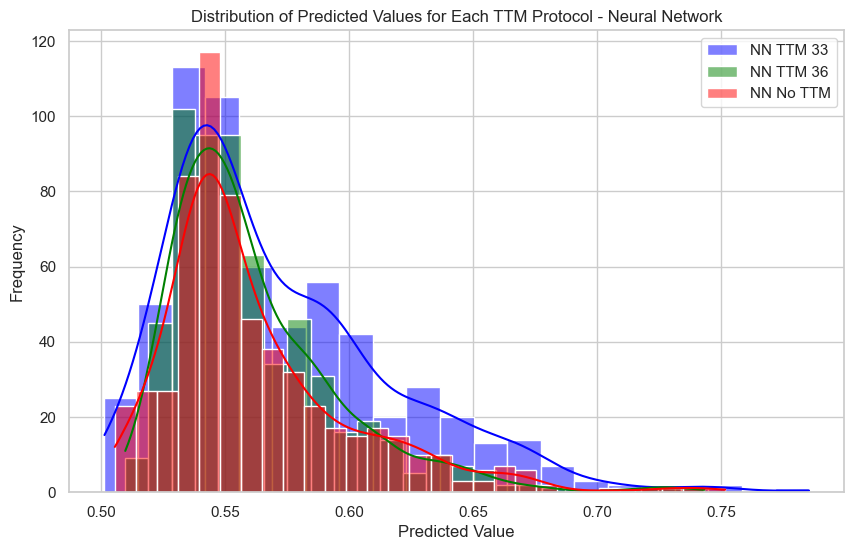

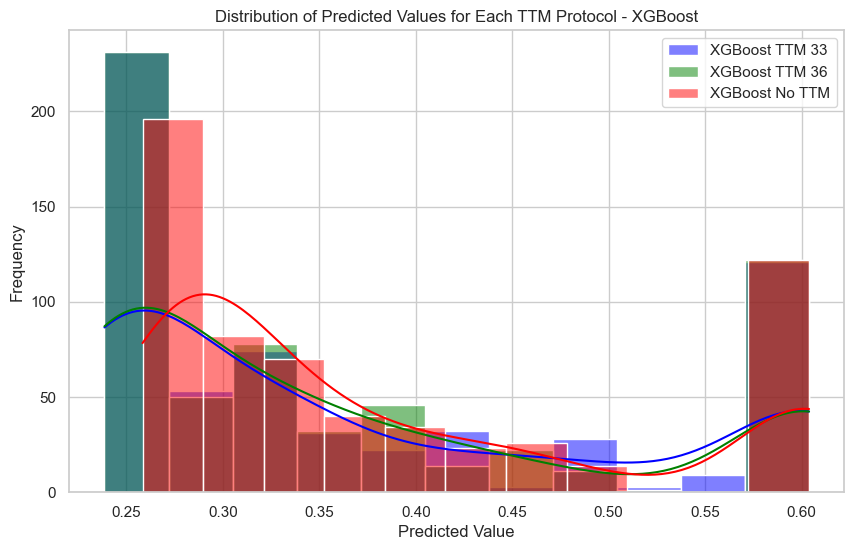

Neural Network Predictions - Number of data points for TTM 33: 607
Neural Network Predictions - Number of data points for TTM 36: 607
Neural Network Predictions - Number of data points for No TTM: 607
XGBoost Predictions - Number of data points for TTM 33: 607
XGBoost Predictions - Number of data points for TTM 36: 607
XGBoost Predictions - Number of data points for No TTM: 607


In [14]:
# Set up the figure for Neural Network predictions
plt.figure(figsize=(10, 6))
sns.histplot(combined_predictions_df['NN_Pred_TTM_33'], color="blue", label="NN TTM 33", kde=True)
sns.histplot(combined_predictions_df['NN_Pred_TTM_36'], color="green", label="NN TTM 36", kde=True)
sns.histplot(combined_predictions_df['NN_Pred_No_TTM'], color="red", label="NN No TTM", kde=True)
plt.title("Distribution of Predicted Values for Each TTM Protocol - Neural Network")
plt.xlabel("Predicted Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Set up the figure for XGBoost predictions
plt.figure(figsize=(10, 6))
sns.histplot(combined_predictions_df['xgb_Pred_TTM_33'], color="blue", label="XGBoost TTM 33", kde=True)
sns.histplot(combined_predictions_df['xgb_Pred_TTM_36'], color="green", label="XGBoost TTM 36", kde=True)
sns.histplot(combined_predictions_df['xgb_Pred_No_TTM'], color="red", label="XGBoost No TTM", kde=True)
plt.title("Distribution of Predicted Values for Each TTM Protocol - XGBoost")
plt.xlabel("Predicted Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Calculate the number of data points for each TTM protocol in NN predictions
num_points_nn_ttm_33 = combined_predictions_df['NN_Pred_TTM_33'].notnull().sum()
num_points_nn_ttm_36 = combined_predictions_df['NN_Pred_TTM_36'].notnull().sum()
num_points_nn_no_ttm = combined_predictions_df['NN_Pred_No_TTM'].notnull().sum()

# Calculate the number of data points for each TTM protocol in XGBoost predictions
num_points_xgb_ttm_33 = combined_predictions_df['xgb_Pred_TTM_33'].notnull().sum()
num_points_xgb_ttm_36 = combined_predictions_df['xgb_Pred_TTM_36'].notnull().sum()
num_points_xgb_no_ttm = combined_predictions_df['xgb_Pred_No_TTM'].notnull().sum()

# Display the counts
print(f"Neural Network Predictions - Number of data points for TTM 33: {num_points_nn_ttm_33}")
print(f"Neural Network Predictions - Number of data points for TTM 36: {num_points_nn_ttm_36}")
print(f"Neural Network Predictions - Number of data points for No TTM: {num_points_nn_no_ttm}")

print(f"XGBoost Predictions - Number of data points for TTM 33: {num_points_xgb_ttm_33}")
print(f"XGBoost Predictions - Number of data points for TTM 36: {num_points_xgb_ttm_36}")
print(f"XGBoost Predictions - Number of data points for No TTM: {num_points_xgb_no_ttm}")


## 5. Let Them Vote <a id="let-them-vote"></a>

In this chapter, we integrate the predictions from both models—Neural Network (NN) and XGBoost—to identify consensus on the best TTM protocol for each patient. By leveraging a "voting" approach, we aim to ensure that:
- The selected protocol reflects agreement between both models, adding robustness to the decision.
- Changes to the original protocol are significant and consistent across models.

### Objectives:
1. **Model Agreement**:
   - Identify cases where both NN and XGBoost agree on the optimal protocol.
   - Highlight patients where the agreed-upon protocol differs from the original.
2. **Consensus-Based Decisions**:
   - Create an "Overall Best TTM" column to reflect the agreed-upon best protocol for each patient.
3. **Insights and Visualizations**:
   - Use Sankey diagrams to visualize protocol transitions under the consensus-based approach.
   - Analyze patterns in numerical and categorical features for patients undergoing protocol changes.

This chapter consolidates insights from both models to provide a unified perspective on the impact of TTM protocols, laying the foundation for a more robust and clinically relevant analysis.

[Back to Table of Contents](#table-of-contents)

In [15]:
# Filter rows where both NN and XGBoost Best_Prediction match and differ from Original_TTM
changed_protocol_df = combined_predictions_df[
    (combined_predictions_df['Best_Prediction_NN'] == combined_predictions_df['Best_Prediction_XGB']) &  # NN and XGBoost best predictions are the same
    (combined_predictions_df['Best_Prediction_NN'] != combined_predictions_df['Original_TTM'])           # They differ from the original TTM
]

# Display the filtered DataFrame
changed_protocol_df


,Patient,Original_TTM,Outcome,NN_Pred_TTM_33,NN_Pred_TTM_36,NN_Pred_No_TTM,xgb_Pred_TTM_33,xgb_Pred_TTM_36,xgb_Pred_No_TTM,NN_TTM_33_Asses,NN_TTM_36_Asses,NN_No_TTM_Asses,xgb_TTM_33_Asses,xgb_TTM_36_Asses,xgb_No_TTM_Asses,Best_Prediction_NN,Best_Prediction_XGB
28,352,36,1,0.665704,0.604267,0.623257,0.482250,0.447286,0.447286,Higher,Original TTM,Same,Higher,Original TTM,Same,33,33
60,387,36,1,0.644313,0.581860,0.605729,0.437252,0.403010,0.403010,Higher,Original TTM,Same,Higher,Original TTM,Same,33,33
67,396,33,0,0.516168,0.551758,0.551976,0.240703,0.240703,0.277403,Original TTM,Higher,Higher,Original TTM,Same,Higher,No TTM,No TTM
82,413,36,1,0.650568,0.612758,0.635324,0.482250,0.447286,0.447286,Higher,Original TTM,Same,Higher,Original TTM,Same,33,33
108,440,33,0,0.519137,0.556121,0.550975,0.348533,0.348533,0.416750,Original TTM,Higher,Higher,Original TTM,Same,Higher,No TTM,No TTM
124,458,33,0,0.533527,0.551949,0.559507,0.240703,0.240703,0.277403,Original TTM,Same,Higher,Original TTM,Same,Higher,No TTM,No TTM
125,459,33,0,0.512148,0.550471,0.551735,0.240155,0.240155,0.275830,Original TTM,Higher,Higher,Original TTM,Same,Higher,No TTM,No TTM
141,475,36,1,0.618729,0.564327,0.578815,0.437252,0.403010,0.403010,Higher,Original TTM,Same,Higher,Original TTM,Same,33,33
162,504,36,1,0.612922,0.566671,0.576526,0.435272,0.401075,0.401075,Higher,Original TTM,Same,Higher,Original TTM,Same,33,33
183,530,36,0,0.629098,0.577646,0.598922,0.434997,0.400806,0.400806,Higher,Original TTM,Same,Higher,Original TTM,Same,33,33


In [16]:
# KI Colors for the diagram
KI_COLORS = {
    "lightblue": "#EDF4F4",  # Good Outcome
    "lightorange": "#FEEEEB",  # Poor Outcome
    "grey": "#7D7D7D",    # No TTM or unchanged connections
    "bright_purple": "#870052",  # For changed group paths
    "plum": "#4F0433",
    "orange": "#FF876F"
}

# Step 1: Create a new column 'Overall_Best_TTM' in combined_predictions_df
combined_predictions_df['Overall_Best_TTM'] = combined_predictions_df.apply(
    lambda row: row['Best_Prediction_NN'] if row['Best_Prediction_NN'] == row['Best_Prediction_XGB'] else row['Original_TTM'],
    axis=1
)

# Step 2: Define a function to create the Sankey diagram and save it as SVG
def create_sankey_with_overall_best(data, output_file='sankey_diagram.svg'):
    # Count the transitions from Original_TTM to Overall_Best_TTM
    sankey_data = data.groupby(['Original_TTM', 'Overall_Best_TTM']).size().reset_index(name='count')
    
    # Define unique nodes for original and best protocols
    original_nodes = [f"Original {protocol}" for protocol in sankey_data['Original_TTM'].unique()]
    best_nodes = [f"Overall Best {protocol}" for protocol in sankey_data['Overall_Best_TTM'].unique()]
    nodes = original_nodes + best_nodes
    
    # Map each node to a unique index for Sankey
    node_map = {node: i for i, node in enumerate(nodes)}
    
    # Define the sources, targets, and values for the Sankey diagram
    sankey_data['source'] = sankey_data['Original_TTM'].map(lambda x: node_map[f"Original {x}"])
    sankey_data['target'] = sankey_data['Overall_Best_TTM'].map(lambda x: node_map[f"Overall Best {x}"])
    sources = sankey_data['source'].tolist()
    targets = sankey_data['target'].tolist()
    values = sankey_data['count'].tolist()
    
    # Sort the data so changed paths (bright purple) appear last for layering
    sankey_data['is_changed'] = sankey_data['Original_TTM'] != sankey_data['Overall_Best_TTM']
    sankey_data = sankey_data.sort_values(by='is_changed')  # Grey first, then purple
    
    # Redefine sources, targets, values with sorted data
    sources = sankey_data['source'].tolist()
    targets = sankey_data['target'].tolist()
    values = sankey_data['count'].tolist()
    
    # Define link colors
    link_colors = [
        KI_COLORS['bright_purple'] if row['is_changed'] else KI_COLORS['grey']
        for _, row in sankey_data.iterrows()
    ]

    # Create the Sankey diagram
    fig = go.Figure(go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=nodes,
            color=[KI_COLORS['lightblue'], KI_COLORS['lightorange'], KI_COLORS['orange'], KI_COLORS['lightblue'], KI_COLORS['orange'], KI_COLORS['lightorange']]
        ),
        link=dict(
            source=sources,  # Indices of source nodes
            target=targets,  # Indices of target nodes
            value=values,    # Flow values between nodes
            color=link_colors  # Custom link colors
        )
    ))
    
    # Adjust layout for a less wide figure
    fig.update_layout(
        title_text="Sankey Diagram of TTM Protocol Changes (Original to Overall Best Prediction)",
        font_size=12,
        width=800,  # Set the width of the figure
        height=600  # Set the height of the figure
    )

# Step 3: Generate the Sankey diagram and save it as an SVG file
create_sankey_with_overall_best(combined_predictions_df, output_file='sankey_diagram.png')


In [17]:
# List of numerical and categorical columns based on `patient_data`
numerical_cols = ['age', 'rosc']
categorical_cols = ['sex', 'ohca', 'ttm', 'shockable_rhythm']

# Ensure `changed_protocol_original` is defined by merging `changed_protocol_df` with `patient_data`
changed_protocol_original = changed_protocol_df.merge(
    patient_data[['Patient'] + numerical_cols + categorical_cols],
    on='Patient',
    suffixes=('_standardized', '_original')
)

# Dictionary to store results for each transition type
results = {}

# List of protocol transitions to analyze
transitions = [
    ('33', '36'),
    ('36', '33'),
    ('33', 'No TTM'),
    ('36', 'No TTM'),
    ('No TTM', '33'),
    ('No TTM', '36')
]

# Calculate means/modes for each specific transition type using original values
for original, best in transitions:
    # Filter for the specific transition where both NN and XGB agree on the best prediction
    transition_df = changed_protocol_original[
        (changed_protocol_original['Original_TTM'] == original) &
        (changed_protocol_original['Best_Prediction_NN'] == best) &
        (changed_protocol_original['Best_Prediction_XGB'] == best)
    ]
    
    if not transition_df.empty:
        # Calculate mean values for numerical features
        feature_means_original = transition_df[numerical_cols].mean()
        
        # Calculate mode for categorical features
        feature_modes_original = transition_df[categorical_cols].mode().iloc[0]
        
        # Count of cases for this transition
        num_cases = len(transition_df)
        
        # Add the count of cases as the first row in the result
        combined_features = pd.concat([pd.Series({'Number of Cases': num_cases}), feature_means_original, feature_modes_original])
        
        # Store the results in a dictionary with the transition name as the key
        results[f'{original} to {best}'] = combined_features

# Convert the results dictionary to a DataFrame for easier comparison
comparison_df = pd.DataFrame(results)

# Display the comparison table with original values, including categorical feature modes
comparison_df


,36 to 33,33 to No TTM,No TTM to 33
Number of Cases,10,12,1
age,58.7,72.833333,37.0
rosc,NaN,36.0,16.0
sex,Male,Female,Female
ohca,Unknown,True,False
ttm,36.0,33.0,No TTM
shockable_rhythm,Unknown,True,True


In [18]:
combined_predictions_df.describe()

,Patient,Outcome,NN_Pred_TTM_33,NN_Pred_TTM_36,NN_Pred_No_TTM,xgb_Pred_TTM_33,xgb_Pred_TTM_36,xgb_Pred_No_TTM
count,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000
mean,668.588138,0.370675,0.571694,0.561554,0.562158,0.368957,0.364796,0.382331
std,204.331564,0.483384,0.045890,0.034566,0.038561,0.136601,0.133800,0.123572
min,284.000000,0.000000,0.501261,0.509638,0.505425,0.238660,0.238660,0.258379
25%,488.500000,0.000000,0.538577,0.537000,0.538749,0.250766,0.251144,0.278793
50%,673.000000,0.000000,0.557676,0.551873,0.549715,0.321075,0.318803,0.326089
75%,846.500000,1.000000,0.596398,0.577664,0.575157,0.482250,0.445435,0.452638
max,1020.000000,1.000000,0.785387,0.743231,0.751571,0.603810,0.603810,0.603810


## 6. Analyze the Consensus-Based Decision <a id="analyze-consensus"></a>

This chapter delves into analyzing the outcomes of the consensus-based decision-making process. By examining the patients for whom the Neural Network (NN) and XGBoost models agree on the optimal TTM protocol, we aim to:
- Explore the characteristics of these patients through descriptive analytics.
- Use SHAP analysis to understand the factors influencing the models' decisions.
- Build decision tree models to uncover interpretable rules that highlight the key features driving consensus.

### Subchapters:
1. [**Descriptive Analytics**](#descriptive-analytics): Investigate the demographic, clinical, and physiological features of patients whose TTM protocols changed due to the consensus decision.
2. [**SHAP Analysis**](#shap-analysis): Provide explainable AI insights into the feature contributions for protocol changes, focusing on key subgroups of patients.
3. [**Decision Tree Analysis**](#decision-tree-analysis): Develop decision tree models to identify rules that describe the patients’ characteristics and decision paths for protocol changes.

The results of this chapter will help us better understand the patterns and trends in protocol decisions and establish clear, interpretable guidelines for clinicians.

[Back to Table of Contents](#table-of-contents)


In [19]:
# Define thresholds
xgb_threshold = 0.5
nn_threshold = 0.3464

# Mapping from TTM protocols to prediction columns for NN and XGB
nn_prediction_column_map = {
    '33': 'NN_Pred_TTM_33',
    '36': 'NN_Pred_TTM_36',
    'No TTM': 'NN_Pred_No_TTM'
}

xgb_prediction_column_map = {
    '33': 'xgb_Pred_TTM_33',
    '36': 'xgb_Pred_TTM_36',
    'No TTM': 'xgb_Pred_No_TTM'
}

# Function to check if original prediction was correct for a specific model
def check_original_prediction_correct(row, model_prefix, threshold, prediction_map):
    # Map the original protocol to the appropriate prediction column
    pred_column = prediction_map.get(row['Original_TTM'])
    
    # Check if the column exists in the DataFrame
    if pred_column and pred_column in row:
        predicted_value = row[pred_column]
        predicted_outcome = int(predicted_value > threshold)  # 1 if above threshold, 0 otherwise
        return predicted_outcome == row['Outcome']
    else:
        return None  # or False if you want to indicate missing prediction columns explicitly

# Add column for NN prediction accuracy
changed_protocol_df.insert(
    changed_protocol_df.columns.get_loc('Outcome') + 1,
    'NN_Original_Prediction_Correct',
    changed_protocol_df.apply(
        check_original_prediction_correct, 
        axis=1, 
        model_prefix='NN', 
        threshold=nn_threshold, 
        prediction_map=nn_prediction_column_map
    )
)

# Add column for XGB prediction accuracy
changed_protocol_df.insert(
    changed_protocol_df.columns.get_loc('Outcome') + 2,
    'XGB_Original_Prediction_Correct',
    changed_protocol_df.apply(
        check_original_prediction_correct, 
        axis=1, 
        model_prefix='xgb', 
        threshold=xgb_threshold, 
        prediction_map=xgb_prediction_column_map
    )
)

# Display the updated DataFrame
changed_protocol_df.head()


,Patient,Original_TTM,Outcome,NN_Original_Prediction_Correct,XGB_Original_Prediction_Correct,NN_Pred_TTM_33,NN_Pred_TTM_36,NN_Pred_No_TTM,xgb_Pred_TTM_33,xgb_Pred_TTM_36,xgb_Pred_No_TTM,NN_TTM_33_Asses,NN_TTM_36_Asses,NN_No_TTM_Asses,xgb_TTM_33_Asses,xgb_TTM_36_Asses,xgb_No_TTM_Asses,Best_Prediction_NN,Best_Prediction_XGB
28,352,36,1,True,False,0.665704,0.604267,0.623257,0.482250,0.447286,0.447286,Higher,Original TTM,Same,Higher,Original TTM,Same,33,33
60,387,36,1,True,False,0.644313,0.581860,0.605729,0.437252,0.403010,0.403010,Higher,Original TTM,Same,Higher,Original TTM,Same,33,33
67,396,33,0,False,True,0.516168,0.551758,0.551976,0.240703,0.240703,0.277403,Original TTM,Higher,Higher,Original TTM,Same,Higher,No TTM,No TTM
82,413,36,1,True,False,0.650568,0.612758,0.635324,0.482250,0.447286,0.447286,Higher,Original TTM,Same,Higher,Original TTM,Same,33,33
108,440,33,0,False,True,0.519137,0.556121,0.550975,0.348533,0.348533,0.416750,Original TTM,Higher,Higher,Original TTM,Same,Higher,No TTM,No TTM


In [20]:
# Function to get the prediction outcome based on a specific TTM protocol
def get_prediction_outcome(row, model_prefix, threshold, prediction_map, ttm_protocol):
    # Get the prediction column based on the TTM protocol
    pred_column = prediction_map.get(ttm_protocol)
    if pred_column and pred_column in row:
        predicted_value = row[pred_column]
        # Determine outcome (0 or 1) based on the threshold
        return int(predicted_value > threshold)
    else:
        return None  # Handle missing prediction column if needed

# Function to determine if prediction outcome changed between original and best TTM protocols
def did_prediction_change(row, model_prefix, threshold, prediction_map):
    # Original TTM outcome
    original_ttm = row['Original_TTM']
    original_outcome = get_prediction_outcome(row, model_prefix, threshold, prediction_map, original_ttm)
    
    # Best TTM outcome
    best_ttm = row[f'Best_Prediction_{model_prefix.upper()}']
    best_outcome = get_prediction_outcome(row, model_prefix, threshold, prediction_map, best_ttm)
    
    # Compare outcomes to determine if there was a change
    if original_outcome is not None and best_outcome is not None:
        return original_outcome != best_outcome
    else:
        return None  # Or False if you prefer to indicate no change due to missing data

# Ensure changed_protocol_df is an explicit copy of the original data
changed_protocol_df = changed_protocol_df.copy()
    
# Add column to indicate if NN prediction outcome changed between original and best TTM
changed_protocol_df.loc[:, 'NN_Result_Changed'] = changed_protocol_df.apply(
    did_prediction_change, 
    axis=1, 
    model_prefix='NN', 
    threshold=nn_threshold, 
    prediction_map=nn_prediction_column_map
)

# Add column to indicate if XGB prediction outcome changed between original and best TTM
changed_protocol_df.loc[:, 'XGB_Result_Changed'] = changed_protocol_df.apply(
    did_prediction_change, 
    axis=1, 
    model_prefix='xgb', 
    threshold=xgb_threshold, 
    prediction_map=xgb_prediction_column_map
)

# Display the updated DataFrame
changed_protocol_df.head()


,Patient,Original_TTM,Outcome,NN_Original_Prediction_Correct,XGB_Original_Prediction_Correct,NN_Pred_TTM_33,NN_Pred_TTM_36,NN_Pred_No_TTM,xgb_Pred_TTM_33,xgb_Pred_TTM_36,...,NN_TTM_33_Asses,NN_TTM_36_Asses,NN_No_TTM_Asses,xgb_TTM_33_Asses,xgb_TTM_36_Asses,xgb_No_TTM_Asses,Best_Prediction_NN,Best_Prediction_XGB,NN_Result_Changed,XGB_Result_Changed
28,352,36,1,True,False,0.665704,0.604267,0.623257,0.482250,0.447286,...,Higher,Original TTM,Same,Higher,Original TTM,Same,33,33,False,False
60,387,36,1,True,False,0.644313,0.581860,0.605729,0.437252,0.403010,...,Higher,Original TTM,Same,Higher,Original TTM,Same,33,33,False,False
67,396,33,0,False,True,0.516168,0.551758,0.551976,0.240703,0.240703,...,Original TTM,Higher,Higher,Original TTM,Same,Higher,No TTM,No TTM,False,False
82,413,36,1,True,False,0.650568,0.612758,0.635324,0.482250,0.447286,...,Higher,Original TTM,Same,Higher,Original TTM,Same,33,33,False,False
108,440,33,0,False,True,0.519137,0.556121,0.550975,0.348533,0.348533,...,Original TTM,Higher,Higher,Original TTM,Same,Higher,No TTM,No TTM,False,False


NN Result Change Counts:
NN_Result_Changed
False    23
Name: count, dtype: int64

XGB Result Change Counts:
XGB_Result_Changed
False    22
True      1
Name: count, dtype: int64


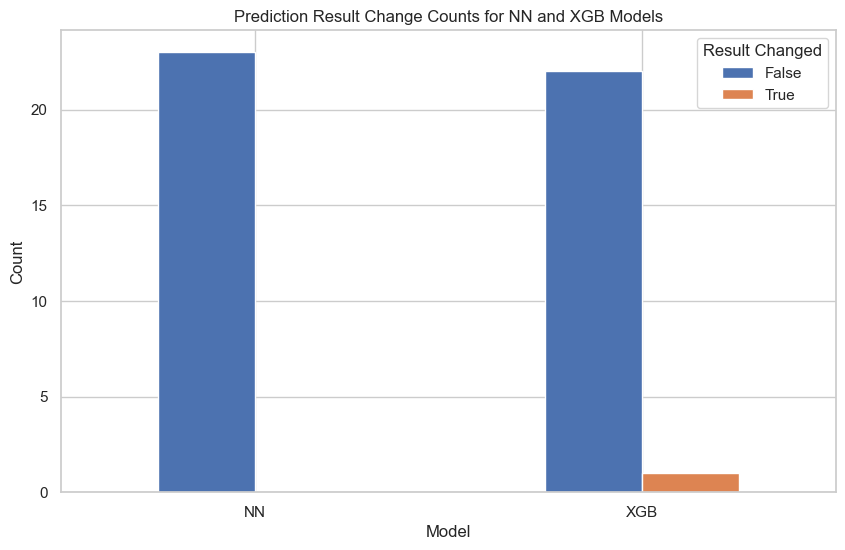

In [21]:
# Print the count of changes for each model
print("NN Result Change Counts:")
print(changed_protocol_df['NN_Result_Changed'].value_counts())

print("\nXGB Result Change Counts:")
print(changed_protocol_df['XGB_Result_Changed'].value_counts())

# Get counts for each change status (True or False) for both NN and XGB
nn_counts = changed_protocol_df['NN_Result_Changed'].value_counts()
xgb_counts = changed_protocol_df['XGB_Result_Changed'].value_counts()

# Create a DataFrame to combine the counts for easy plotting
change_df = pd.DataFrame({
    'NN': nn_counts,
    'XGB': xgb_counts
}).T  # Transpose for better plotting

# Plot the change status as a bar plot
change_df.plot(kind='bar', stacked=False, figsize=(10, 6))
plt.title("Prediction Result Change Counts for NN and XGB Models")
plt.xlabel("Model")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(title="Result Changed")
plt.show()

### **6.1 Descriptive Analytics** <a id="descriptive-analytics"></a> 

In this subchapter, we perform a detailed exploratory analysis of the patient groups whose TTM protocols were updated based on the consensus decision. This includes:
- Comparing distributions of numerical and categorical features between the original and updated protocol groups.
- Visualizing feature trends for patients who underwent a protocol change versus those who did not.

This analysis provides a foundation for understanding the differences between patient groups and identifying key patterns in the data.

[Back to Table of Contents](#table-of-contents)

In [22]:
# Step 1: Define features to plot based on tabular_cols
features_to_plot = tabular_cols
# Remove specific TTM-related features
features_to_plot = [feature for feature in features_to_plot if feature not in ['ttm_33.0', 'ttm_36.0', 'ttm_No TTM']]

# Verify the result
print("Filtered features_to_plot:", features_to_plot)

Filtered features_to_plot: ['age', 'rosc', 'sex_Female', 'sex_Male', 'ohca_True', 'ohca_False', 'ohca_Unknown', 'shockable_rhythm_False', 'shockable_rhythm_True', 'shockable_rhythm_Unknown']


In [23]:
# Remove 'Original_TTM' from combined_data before merging
combined_data_filtered = combined_data[[col for col in combined_data.columns if "Segment" not in col and col != 'Original_TTM']]

# Merge the filtered combined_data with changed_protocol_df on 'Patient' column
merged_df = pd.merge(combined_data_filtered, changed_protocol_df, on='Patient', how='inner')

# Verify the columns to ensure no duplication of 'Original_TTM'
print("Columns in merged_df:", list(merged_df.columns))


Columns in merged_df: ['Patient', 'age', 'sex_Female', 'sex_Male', 'ohca_True', 'ohca_False', 'ohca_Unknown', 'ttm_33.0', 'ttm_36.0', 'ttm_No TTM', 'shockable_rhythm_False', 'shockable_rhythm_True', 'shockable_rhythm_Unknown', 'rosc', 'Patient_ID', 'outcome', 'Original_TTM', 'Outcome', 'NN_Original_Prediction_Correct', 'XGB_Original_Prediction_Correct', 'NN_Pred_TTM_33', 'NN_Pred_TTM_36', 'NN_Pred_No_TTM', 'xgb_Pred_TTM_33', 'xgb_Pred_TTM_36', 'xgb_Pred_No_TTM', 'NN_TTM_33_Asses', 'NN_TTM_36_Asses', 'NN_No_TTM_Asses', 'xgb_TTM_33_Asses', 'xgb_TTM_36_Asses', 'xgb_No_TTM_Asses', 'Best_Prediction_NN', 'Best_Prediction_XGB', 'NN_Result_Changed', 'XGB_Result_Changed']


C:\Users\kentf\AppData\Local\Temp\ipykernel_10992\68828280.py:28: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

C:\Users\kentf\AppData\Local\Temp\ipykernel_10992\68828280.py:41: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

C:\Users\kentf\AppData\Local\Temp\ipykernel_10992\68828280.py:28: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

C:\Users\kentf\AppData\Local\Temp\ipykernel_10992\68828280.py:41: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

C:\Users\kentf\AppData\Local\Temp\ipykernel_10992\68828280.py:28: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

C:\Users\kentf\AppData\Local\Temp\ipykernel_10992\68828280.py:41: UserWarning:



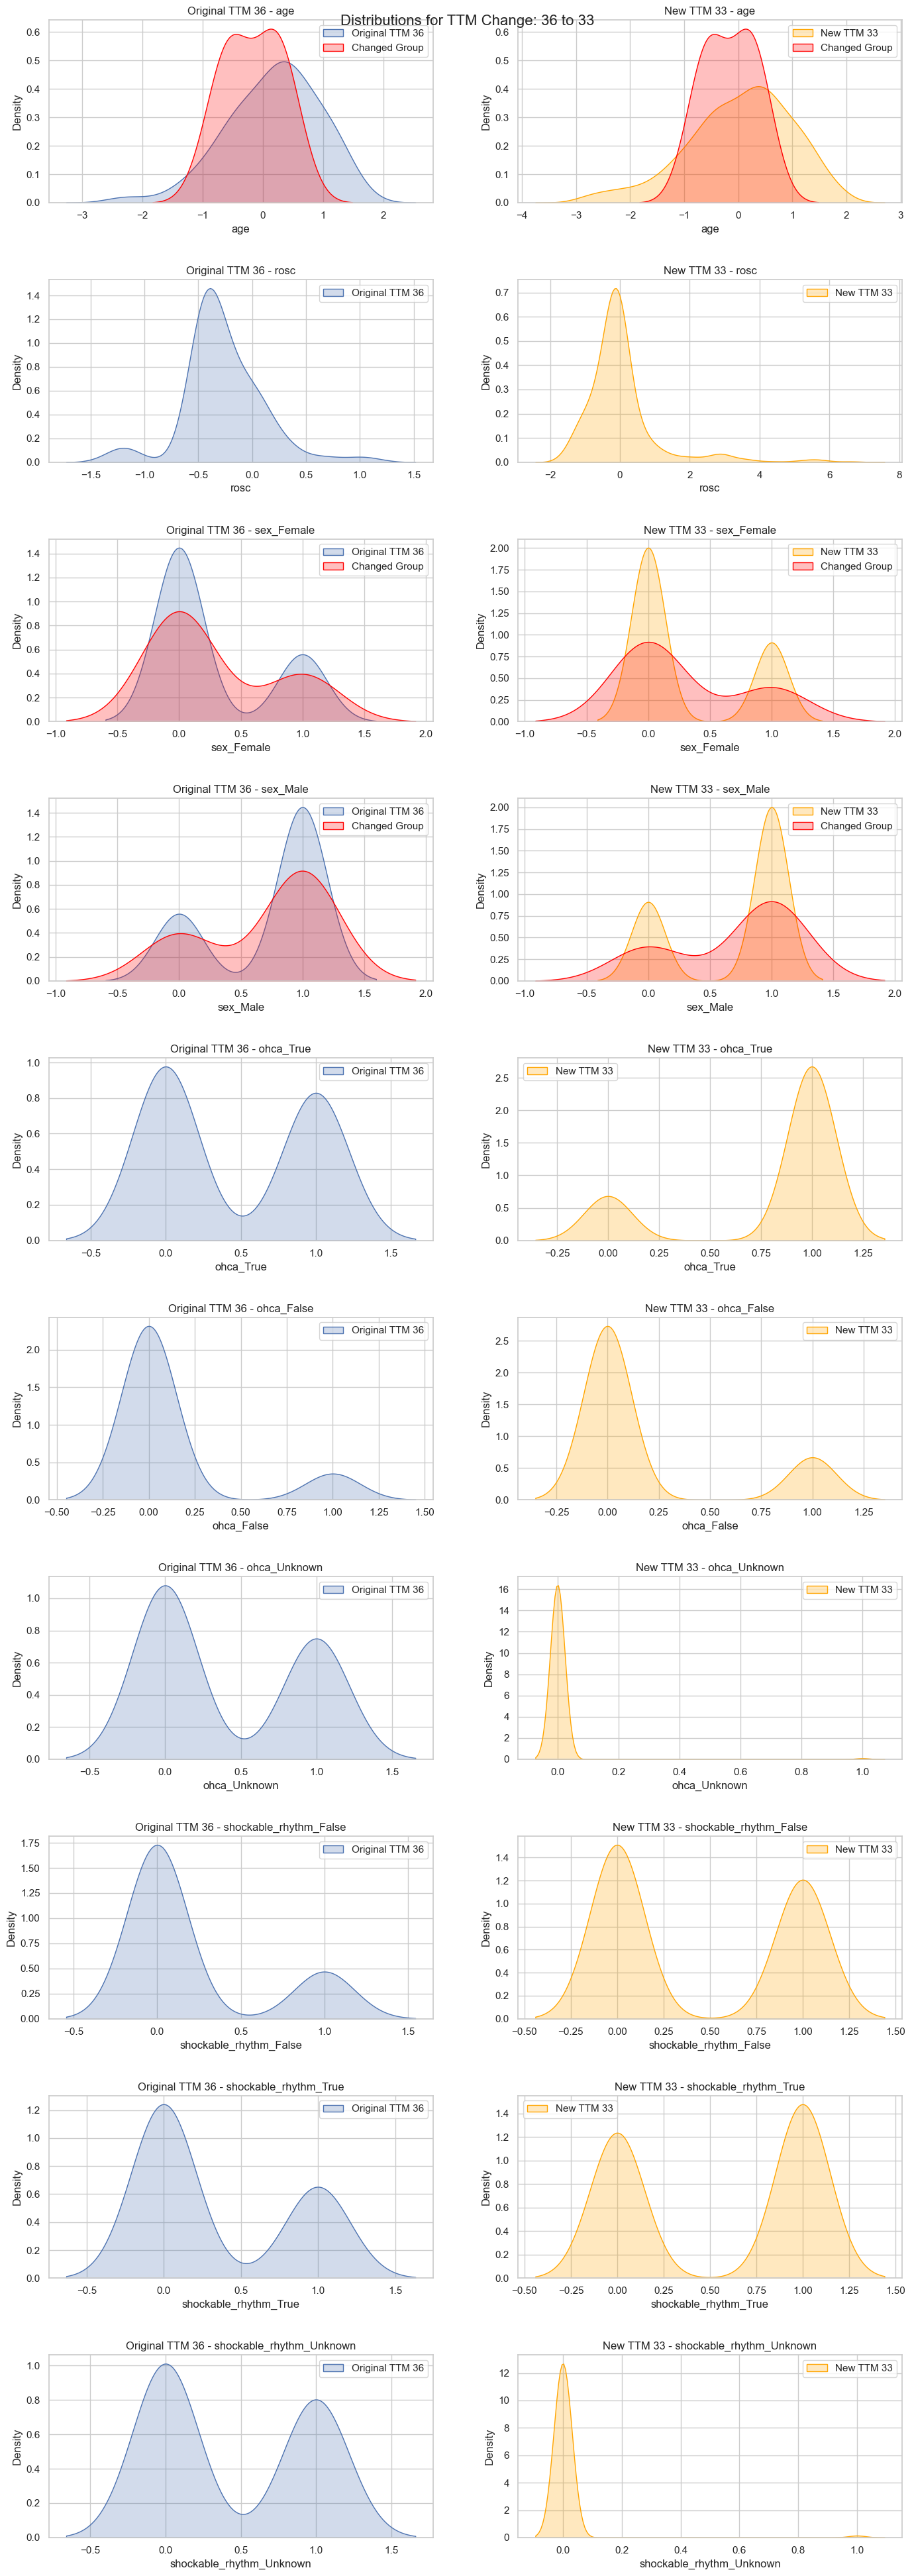

C:\Users\kentf\AppData\Local\Temp\ipykernel_10992\68828280.py:28: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

C:\Users\kentf\AppData\Local\Temp\ipykernel_10992\68828280.py:41: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

C:\Users\kentf\AppData\Local\Temp\ipykernel_10992\68828280.py:28: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

C:\Users\kentf\AppData\Local\Temp\ipykernel_10992\68828280.py:41: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

C:\Users\kentf\AppData\Local\Temp\ipykernel_10992\68828280.py:28: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

C:\Users\kentf\AppData\Local\Temp\ipykernel_10992\68828280.py:41: UserWarning:



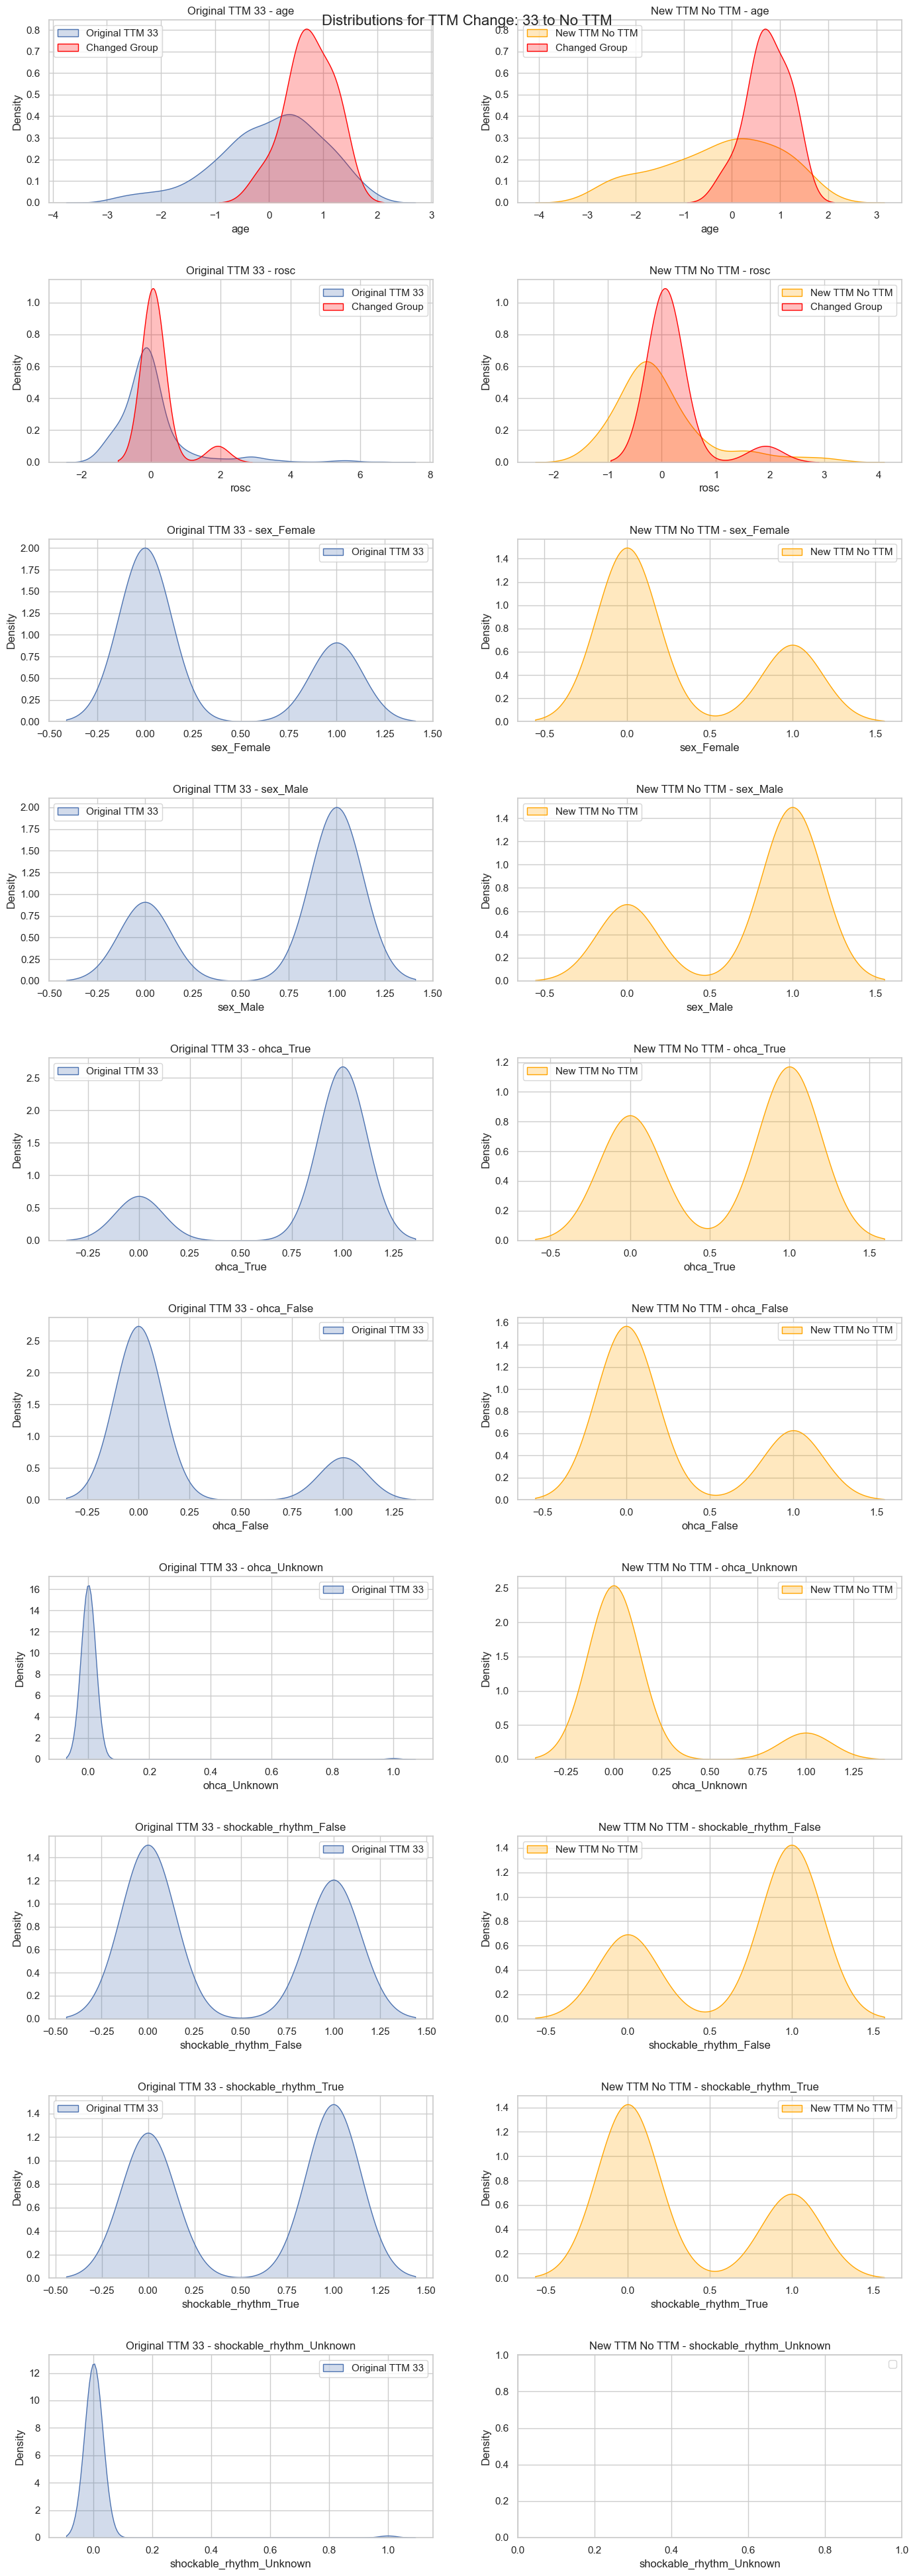

C:\Users\kentf\AppData\Local\Temp\ipykernel_10992\68828280.py:28: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

C:\Users\kentf\AppData\Local\Temp\ipykernel_10992\68828280.py:41: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

C:\Users\kentf\AppData\Local\Temp\ipykernel_10992\68828280.py:28: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

C:\Users\kentf\AppData\Local\Temp\ipykernel_10992\68828280.py:41: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

C:\Users\kentf\AppData\Local\Temp\ipykernel_10992\68828280.py:28: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

C:\Users\kentf\AppData\Local\Temp\ipykernel_10992\68828280.py:41: UserWarning:



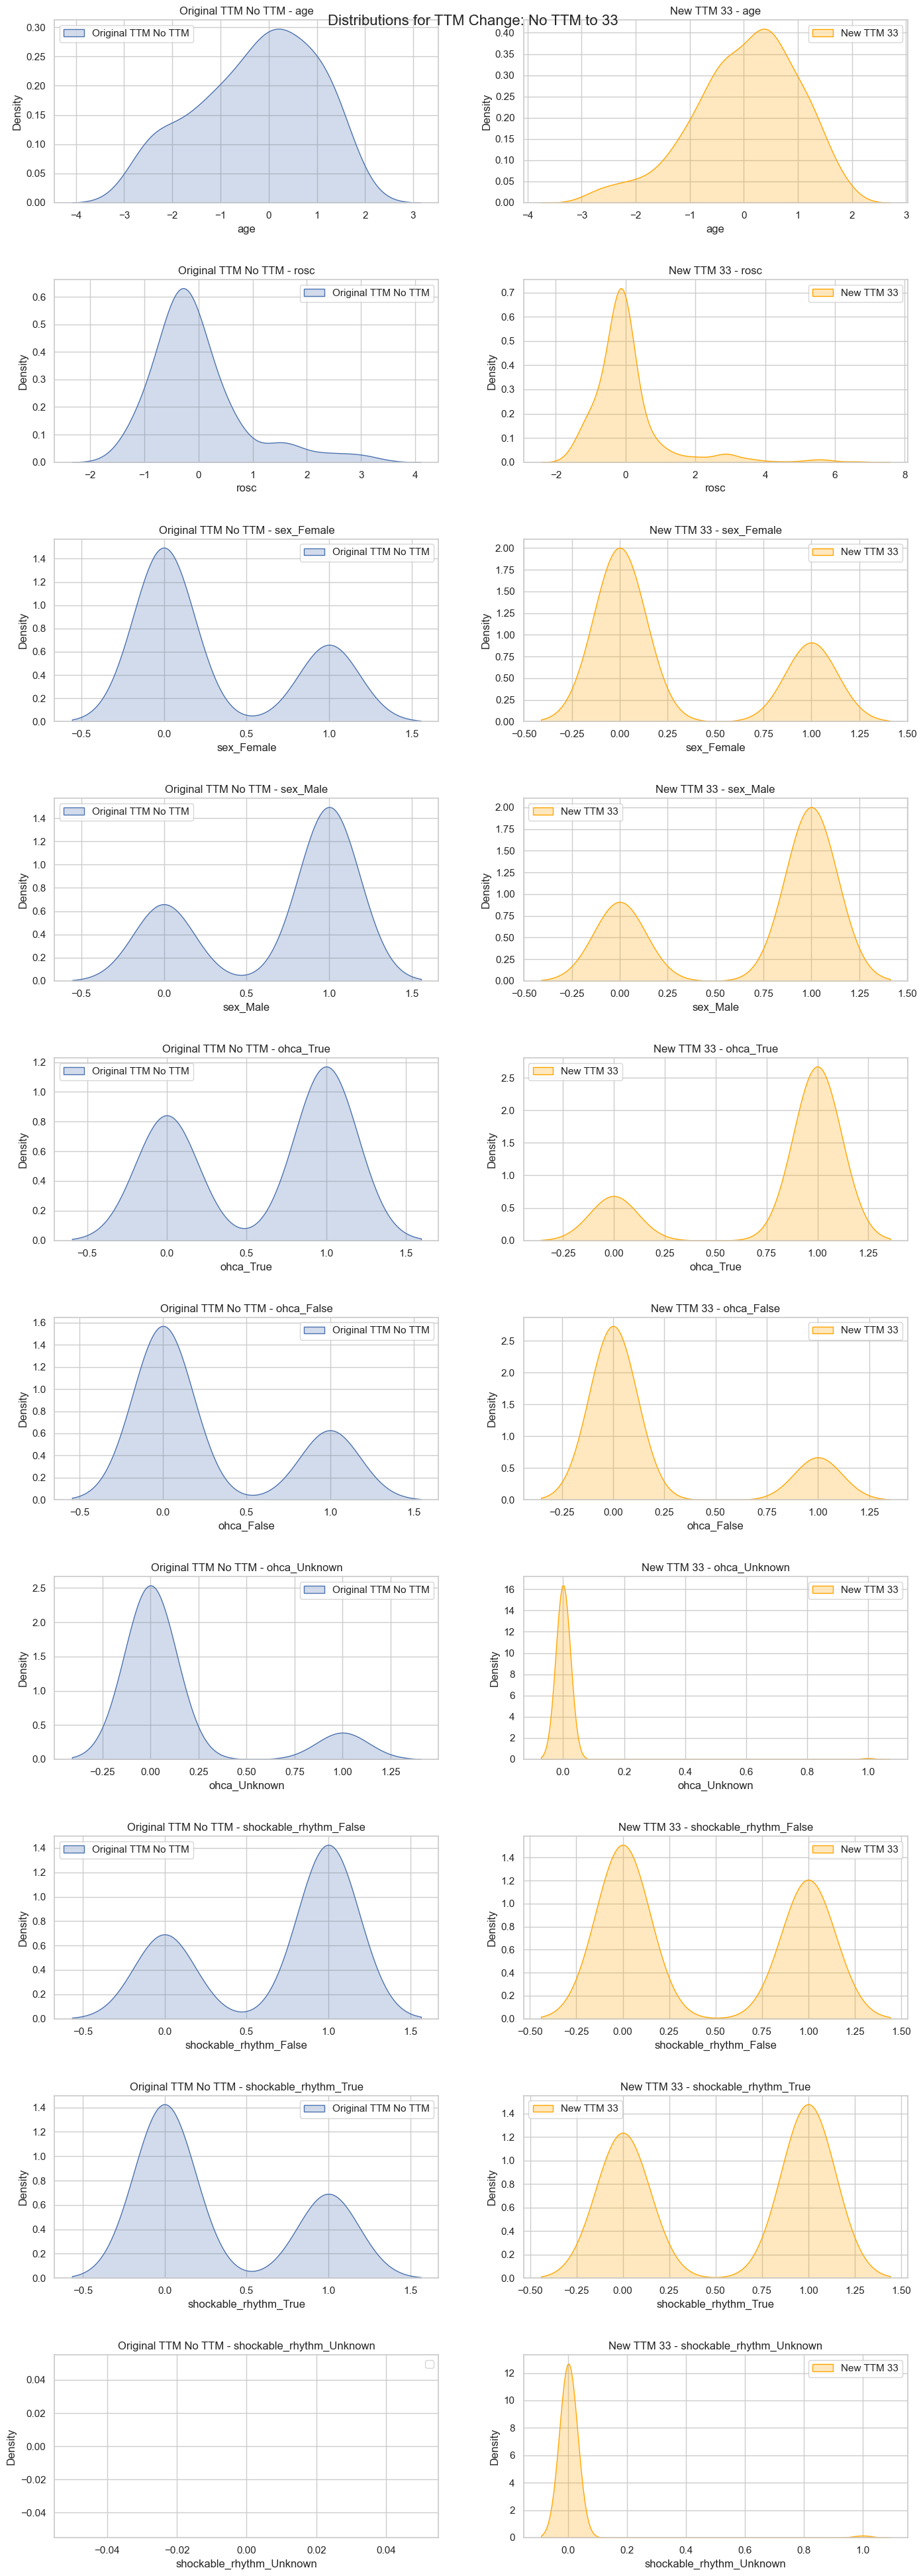

In [24]:
# Get unique pairs of Original TTM to Best TTM from merged_df
group_changes = merged_df[['Original_TTM', 'Best_Prediction_NN']].drop_duplicates()

# Iterate over each unique group change
for _, (original_ttm, best_ttm) in group_changes.iterrows():
    # Filter original group from combined_data for all patients with the Original TTM value
    original_group_all = combined_data[combined_data['Original_TTM'] == original_ttm]
    # Filter new group from combined_data for all patients with the new Best TTM value
    new_group_all = combined_data[combined_data['Original_TTM'] == best_ttm]
    # Filter for only those patients who had a protocol change from original to new TTM
    changed_group = merged_df[(merged_df['Original_TTM'] == original_ttm) & 
                              (merged_df['Best_Prediction_NN'] == best_ttm)]

    # Set up subplots for each feature for this TTM change
    fig, axes = plt.subplots(len(features_to_plot), 2, figsize=(15, len(features_to_plot) * 4))
    fig.tight_layout(pad=5.0)
    
    # Title for the group change
    fig.suptitle(f"Distributions for TTM Change: {original_ttm} to {best_ttm}", fontsize=16)

    # Plot distributions for each feature
    for i, feature in enumerate(features_to_plot):
        # Plot original group distribution and overlay changed group distribution
        sns.kdeplot(
            data=original_group_all, 
            x=feature, fill=True, ax=axes[i, 0], label=f'Original TTM {original_ttm}'
        )
        sns.kdeplot(
            data=changed_group, 
            x=feature, fill=True, ax=axes[i, 0], color="red", label='Changed Group'
        )
        axes[i, 0].set_title(f"Original TTM {original_ttm} - {feature}")
        axes[i, 0].set_xlabel(feature)
        axes[i, 0].legend()

        # Plot new group distribution and overlay changed group distribution
        sns.kdeplot(
            data=new_group_all, 
            x=feature, fill=True, ax=axes[i, 1], label=f'New TTM {best_ttm}', color="orange"
        )
        sns.kdeplot(
            data=changed_group, 
            x=feature, fill=True, ax=axes[i, 1], color="red", label='Changed Group'
        )
        axes[i, 1].set_title(f"New TTM {best_ttm} - {feature}")
        axes[i, 1].set_xlabel(feature)
        axes[i, 1].legend()

    plt.show()


### **6.2 SHAP Analysis** <a id="shap-analysis"></a> 

SHAP (SHapley Additive exPlanations) is used in this subchapter to:
- Explain how individual features contributed to the models’ decisions to change TTM protocols.
- Focus on subgroups of patients with specific protocol changes (e.g., "33 to No TTM") to highlight the driving factors.

By analyzing SHAP values, we gain interpretability into model decisions and can better understand the feature importance for specific protocol transitions.

[Back to Table of Contents](#table-of-contents)

In [25]:
# Create a copy of machine_learning_data
ml_data_copy = machine_learning_patient_data.copy()

# Perform an inner join with changed_protocol_df on 'Patient'
# Selecting only 'Patient', 'Best_Prediction_XGB', and 'Original_TTM' from changed_protocol_df
merged_data = ml_data_copy.merge(
    changed_protocol_df[['Patient', 'Best_Prediction_XGB', 'Original_TTM']], 
    on='Patient', 
    how='inner'
)

# Print the head of the merged DataFrame
merged_data.head()


,Patient,age,sex_Female,sex_Male,ohca_True,ohca_False,ohca_Unknown,ttm_33.0,ttm_36.0,ttm_No TTM,shockable_rhythm_False,shockable_rhythm_True,shockable_rhythm_Unknown,rosc,Best_Prediction_XGB,Original_TTM
0,352,-0.586789,False,True,False,False,True,False,True,False,False,False,True,-0.435870,33,36
1,387,0.245235,False,True,False,False,True,False,True,False,False,False,True,-0.435870,33,36
2,396,0.437240,True,False,True,False,False,True,False,False,False,True,False,0.041898,No TTM,33
3,413,-0.586789,True,False,False,False,True,False,True,False,False,False,True,-0.435870,33,36
4,440,0.693248,True,False,True,False,False,True,False,False,False,True,False,0.299157,No TTM,33


In [26]:
# Step 1: Define groups based on TTM protocol changes
group_36_to_33 = merged_data[(merged_data['Original_TTM'] == '36') & (merged_data['Best_Prediction_XGB'] == '33')]
group_no_ttm_to_33 = merged_data[(merged_data['Original_TTM'] == 'No TTM') & (merged_data['Best_Prediction_XGB'] == '33')]
group_33_to_no_ttm = merged_data[(merged_data['Original_TTM'] == '33') & (merged_data['Best_Prediction_XGB'] == 'No TTM')]

# List of all groups for easier processing
groups = [
    ('36 to 33', group_36_to_33),
    ('No TTM to 33', group_no_ttm_to_33),
    ('33 to No TTM', group_33_to_no_ttm)
]

# Dictionary to store modified groups
modified_groups = {}

# Step 2: For each group, adjust the TTM protocol columns and overwrite in the groups list
for group_name, group in groups:
    print(f"\nGroup: {group_name}")

    # Create a copy to avoid modifying the original `merged_data`
    group_copy = group.copy()

    # Adjust the TTM columns for each patient in the group based on the best and original TTM protocols
    for idx, row in group_copy.iterrows():
        # Set the original TTM to False
        if row['Original_TTM'] == '33':
            group_copy.loc[idx, 'ttm_33.0'] = False
        elif row['Original_TTM'] == '36':
            group_copy.loc[idx, 'ttm_36.0'] = False
        elif row['Original_TTM'] == 'No TTM':
            group_copy.loc[idx, 'ttm_No TTM'] = False
        
        # Set the best-predicted TTM to True
        if row['Best_Prediction_XGB'] == '33':
            group_copy.loc[idx, 'ttm_33.0'] = True
        elif row['Best_Prediction_XGB'] == '36':
            group_copy.loc[idx, 'ttm_36.0'] = True
        elif row['Best_Prediction_XGB'] == 'No TTM':
            group_copy.loc[idx, 'ttm_No TTM'] = True

    # Overwrite the group in `groups` list with the modified `group_copy`
    groups = [(name, group_copy) if name == group_name else (name, grp) for name, grp in groups]
    
    # Save the modified group copy in the dictionary
    modified_groups[group_name] = group_copy

# Display modified groups to verify changes
for group_name, df in modified_groups.items():
    print(f"\nModified Data for Group: {group_name}")
    print(df.head())



Group: 36 to 33

Group: No TTM to 33

Group: 33 to No TTM

Modified Data for Group: 36 to 33
   Patient       age  sex_Female  sex_Male  ohca_True  ohca_False  \
0      352 -0.586789       False      True      False       False   
1      387  0.245235       False      True      False       False   
3      413 -0.586789        True     False      False       False   
7      475  0.309237       False      True      False       False   
8      504 -0.010773       False      True      False       False   

   ohca_Unknown  ttm_33.0  ttm_36.0  ttm_No TTM  shockable_rhythm_False  \
0          True      True     False       False                   False   
1          True      True     False       False                   False   
3          True      True     False       False                   False   
7          True      True     False       False                   False   
8          True      True     False       False                   False   

   shockable_rhythm_True  shockable_rhyt

In [27]:
# Access the "33 to No TTM" group
group_33_to_no_ttm = modified_groups['33 to No TTM']

# Display the first few rows to verify
print("Data for the '33 to No TTM' group:")
group_33_to_no_ttm.head()


Data for the '33 to No TTM' group:


,Patient,age,sex_Female,sex_Male,ohca_True,ohca_False,ohca_Unknown,ttm_33.0,ttm_36.0,ttm_No TTM,shockable_rhythm_False,shockable_rhythm_True,shockable_rhythm_Unknown,rosc,Best_Prediction_XGB,Original_TTM
2,396,0.437240,True,False,True,False,False,False,False,True,False,True,False,0.041898,No TTM,33
4,440,0.693248,True,False,True,False,False,False,False,True,False,True,False,0.299157,No TTM,33
5,458,-0.138776,True,False,True,False,False,False,False,True,False,True,False,0.041898,No TTM,33
6,459,0.693248,True,False,True,False,False,False,False,True,False,True,False,0.041898,No TTM,33
10,536,0.309237,True,False,True,False,False,False,False,True,False,True,False,0.041898,No TTM,33


In [28]:
# Prepare each modified group for SHAP by dropping unnecessary columns
for group_name, df in modified_groups.items():
    # Drop columns 'Patient', 'Best_Prediction_XGB', and 'Original_TTM'
    modified_groups[group_name] = df.drop(['Patient', 'Best_Prediction_XGB', 'Original_TTM'], axis=1)

# Verify by displaying the head of one group, e.g., "33 to No TTM"
print("Data ready for SHAP for the '33 to No TTM' group:")
print(modified_groups['33 to No TTM'].head())


Data ready for SHAP for the '33 to No TTM' group:
         age  sex_Female  sex_Male  ohca_True  ohca_False  ohca_Unknown  \
2   0.437240        True     False       True       False         False   
4   0.693248        True     False       True       False         False   
5  -0.138776        True     False       True       False         False   
6   0.693248        True     False       True       False         False   
10  0.309237        True     False       True       False         False   

    ttm_33.0  ttm_36.0  ttm_No TTM  shockable_rhythm_False  \
2      False     False        True                   False   
4      False     False        True                   False   
5      False     False        True                   False   
6      False     False        True                   False   
10     False     False        True                   False   

    shockable_rhythm_True  shockable_rhythm_Unknown      rosc  
2                    True                     False  0.041898 


Calculating SHAP values for group: 36 to 33
SHAP Summary Plot for group: 36 to 33


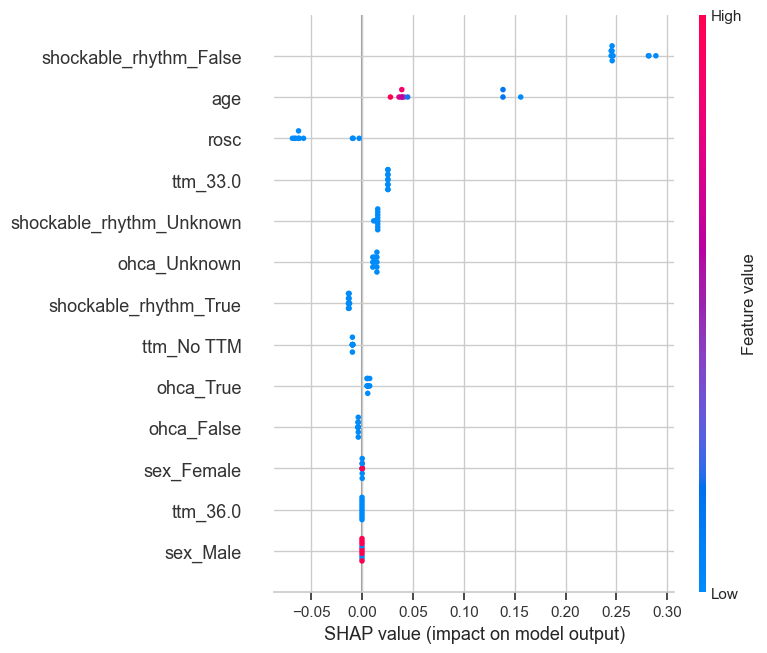


Calculating SHAP values for group: No TTM to 33
SHAP Summary Plot for group: No TTM to 33


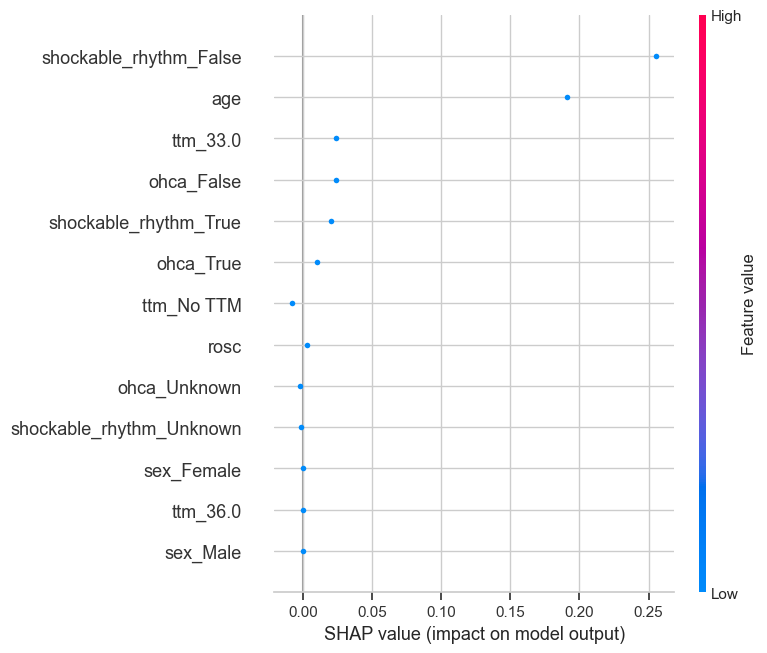


Calculating SHAP values for group: 33 to No TTM
SHAP Summary Plot for group: 33 to No TTM


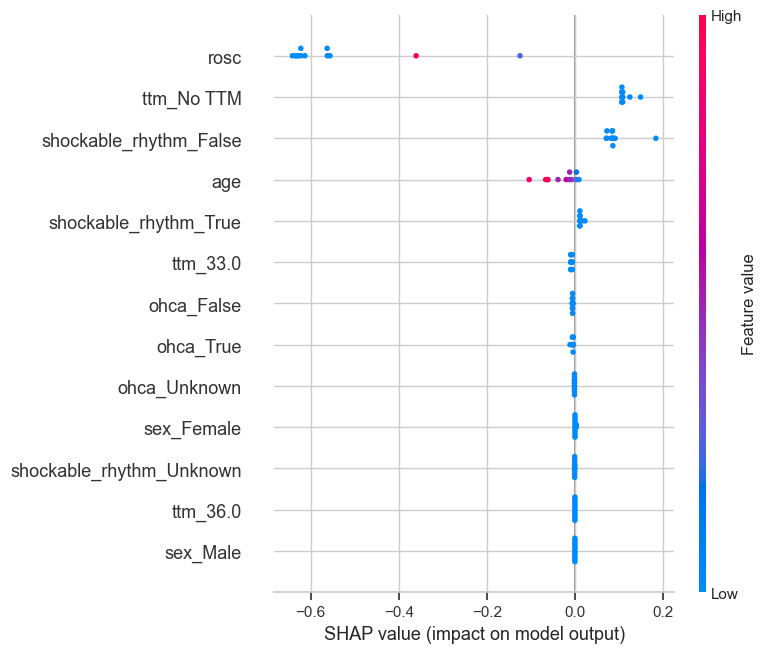

In [29]:
# Initialize SHAP TreeExplainer with the loaded XGBoost model
explainer = shap.TreeExplainer(xgboost)

# Loop over each group and calculate SHAP values
for group_name, group_data in modified_groups.items():
    print(f"\nCalculating SHAP values for group: {group_name}")

    # Calculate SHAP values for the current group
    shap_values = explainer.shap_values(group_data)

    # Plot a SHAP summary plot for the current group
    print(f"SHAP Summary Plot for group: {group_name}")
    shap.summary_plot(shap_values, group_data, show=False)  # Set show=False for custom plt.show()
    plt.show()  # Display the plot inline



SHAP Waterfall Plots for individual patients in group: 36 to 33


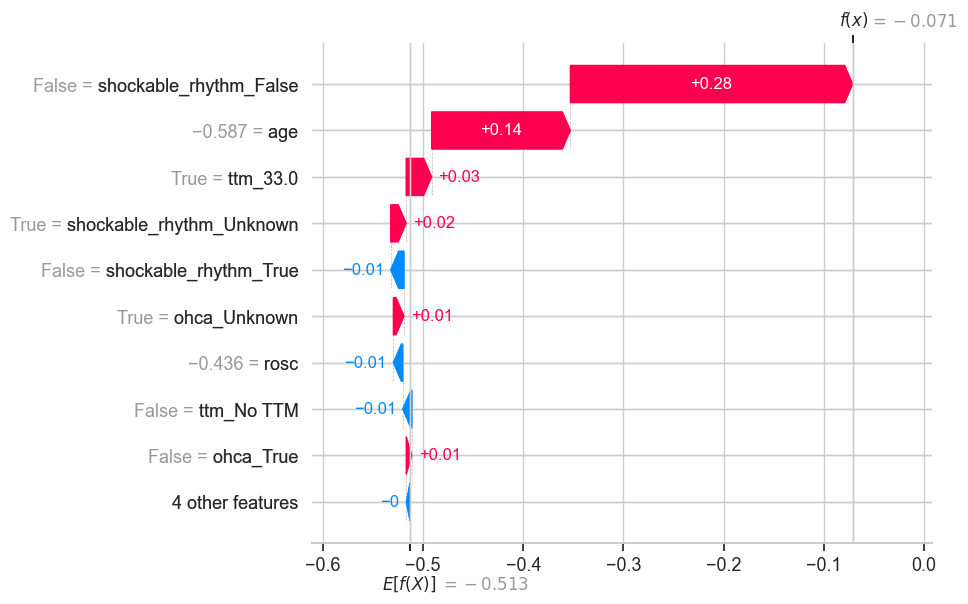

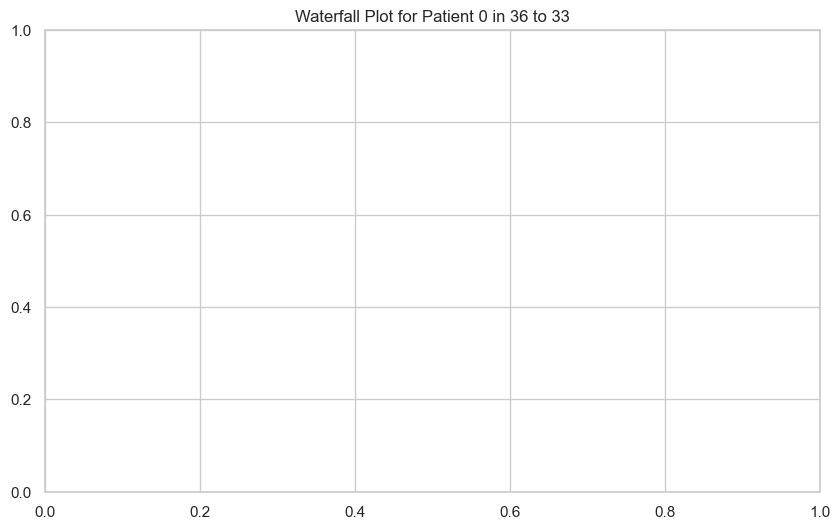

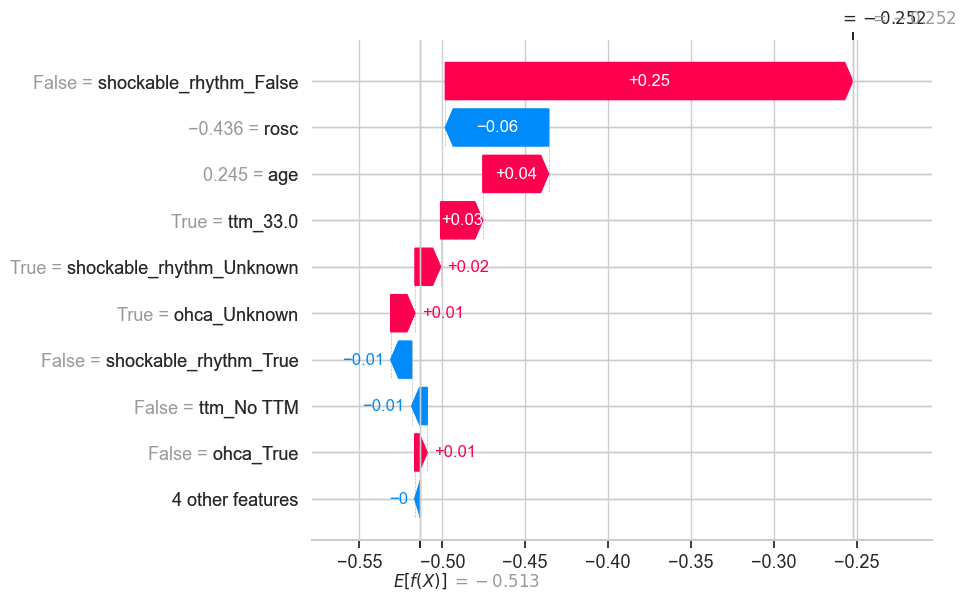

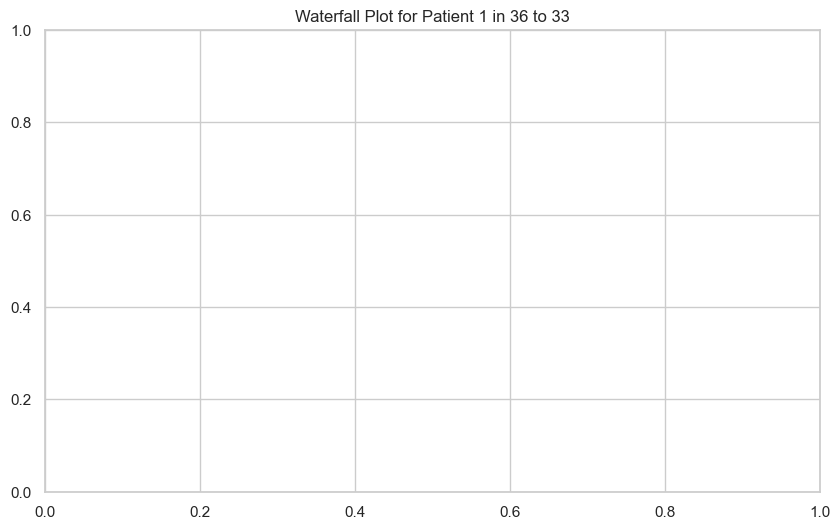

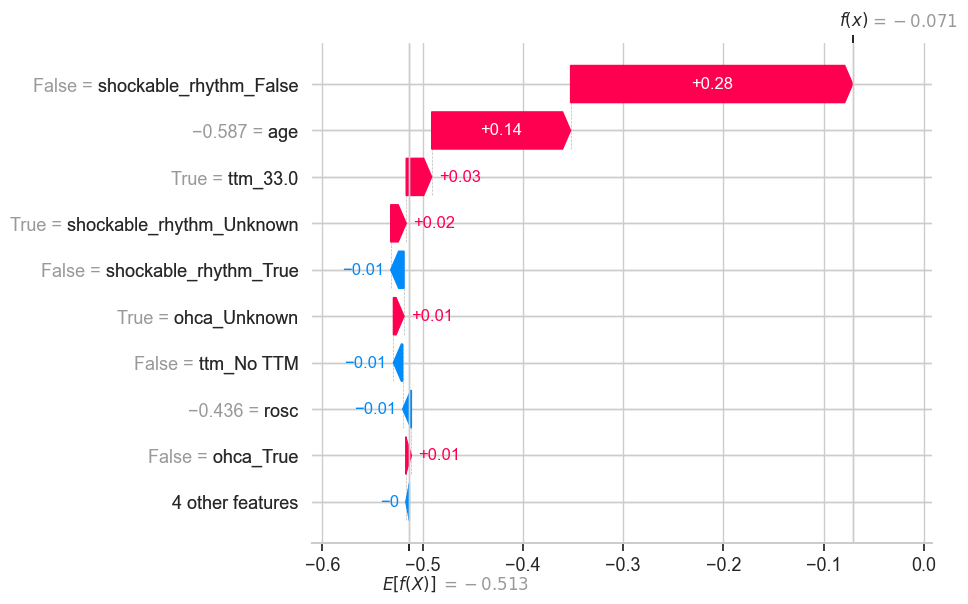

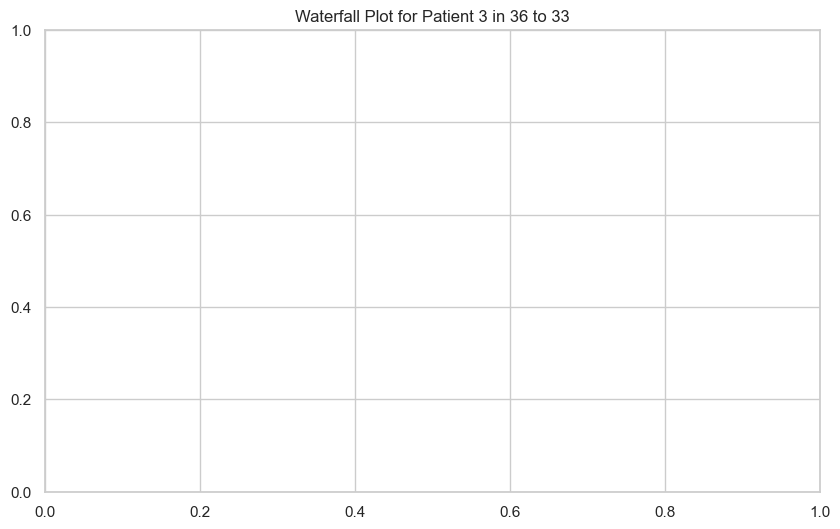


SHAP Waterfall Plots for individual patients in group: No TTM to 33


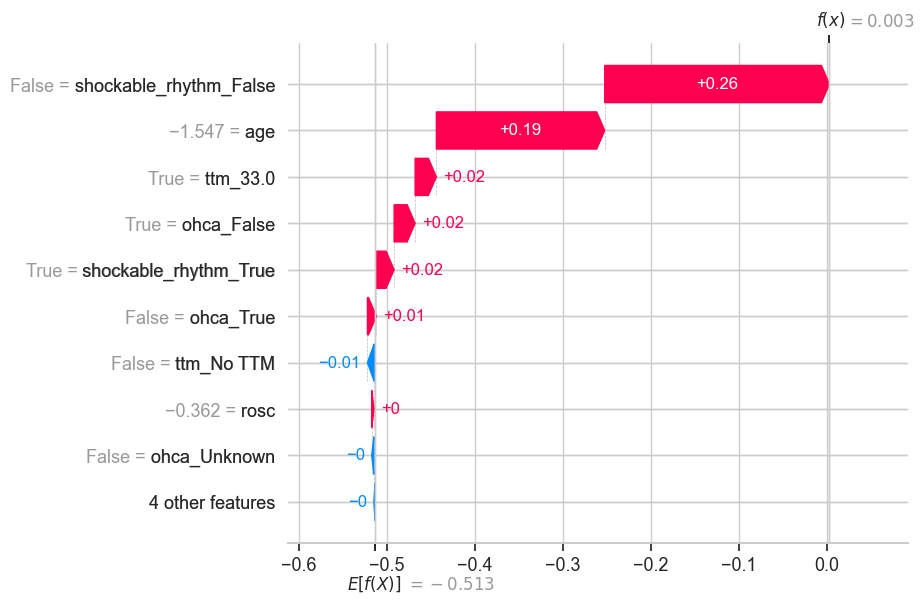

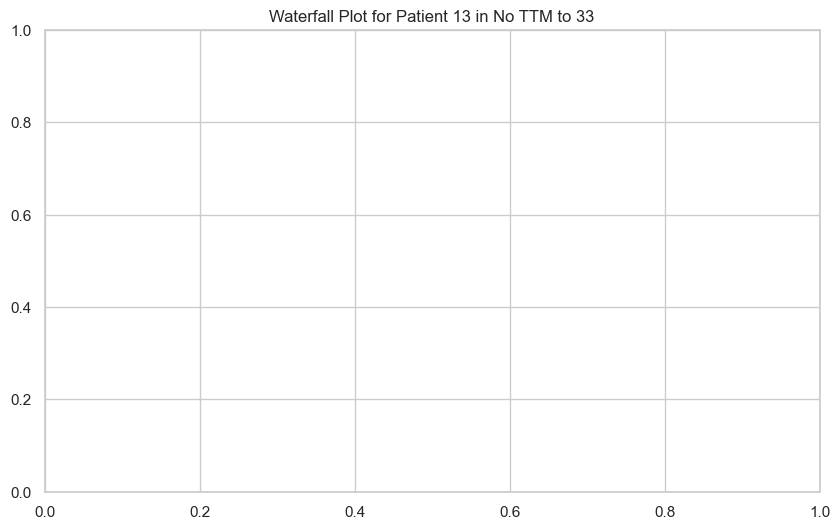


SHAP Waterfall Plots for individual patients in group: 33 to No TTM


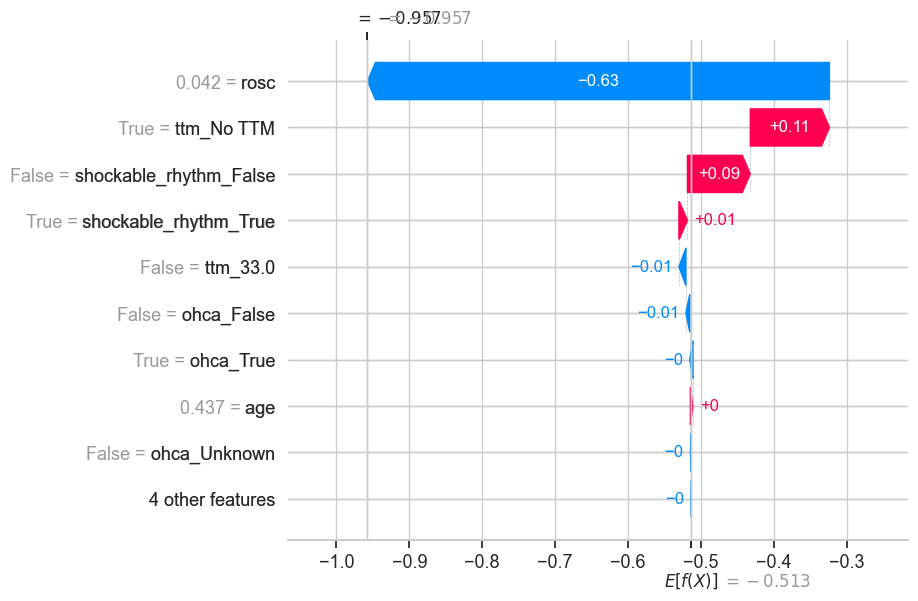

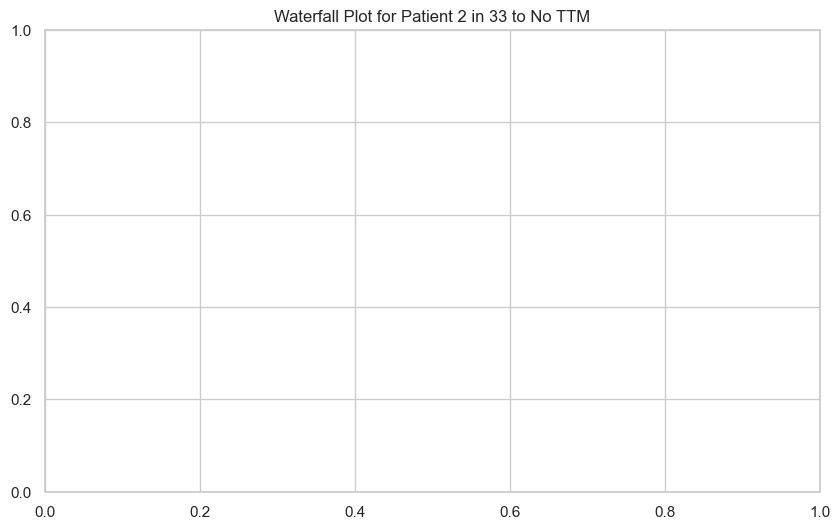

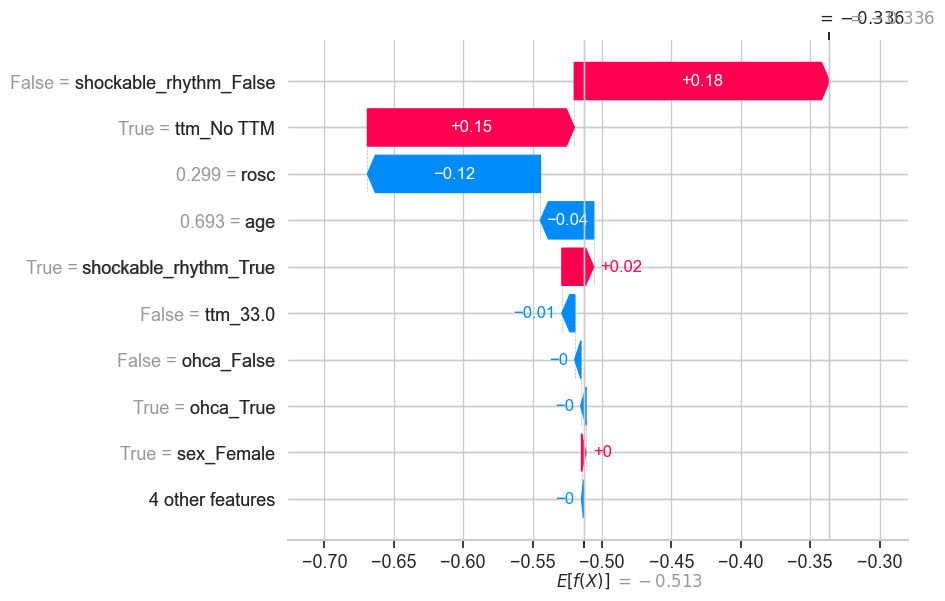

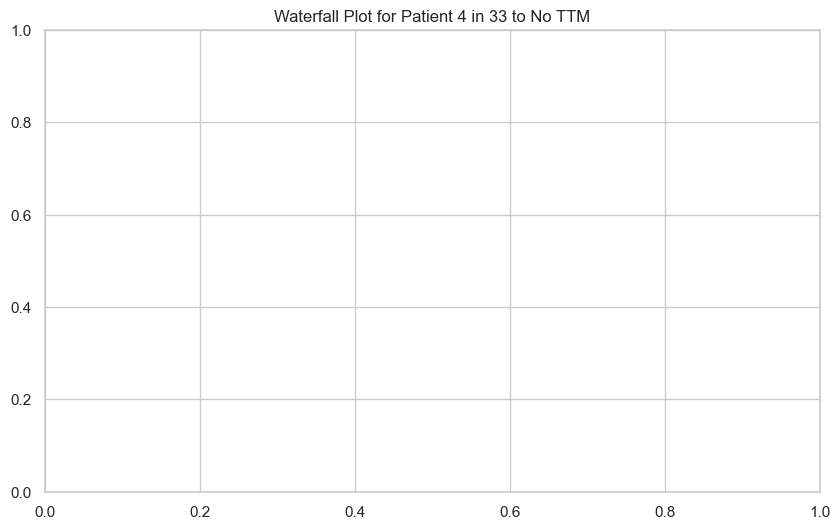

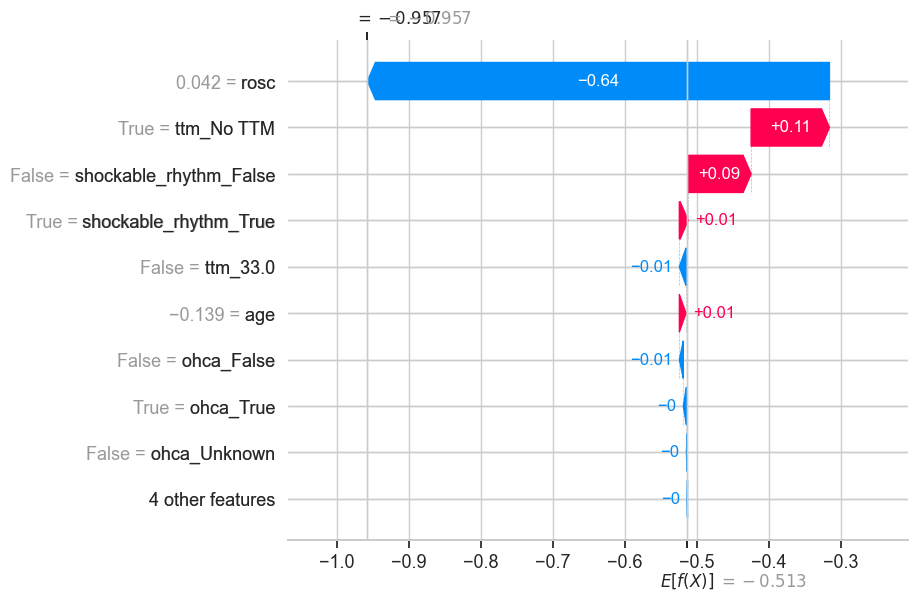

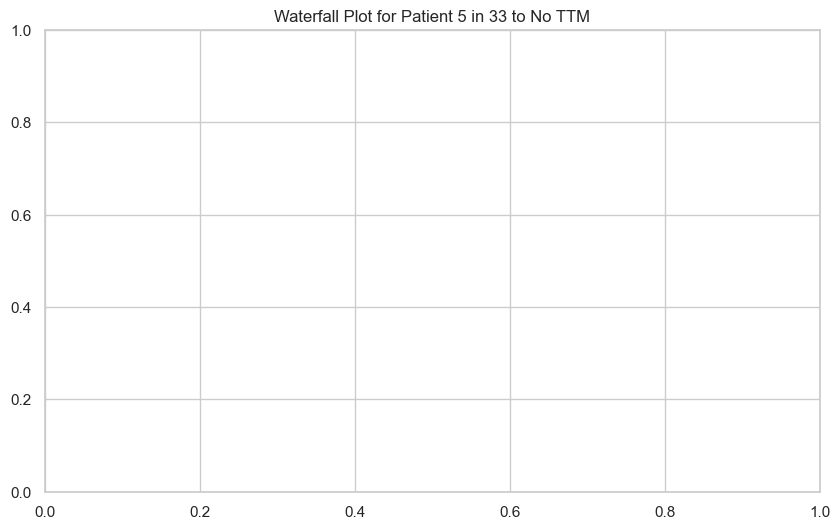

In [30]:
# Display waterfall plots for up to 3 patients in each group, handling cases with fewer than 3 entries
for group_name, group_data in modified_groups.items():
    print(f"\nSHAP Waterfall Plots for individual patients in group: {group_name}")

    # Calculate SHAP values for the current group
    shap_values = explainer.shap_values(group_data)

    # Determine the number of patients to display (minimum of 3 or total patients in group)
    num_patients = min(3, len(group_data))

    # Generate waterfall plots for up to 3 patients in this group
    for i in range(num_patients):
        # Create a waterfall plot for the SHAP values of the current patient
        shap.waterfall_plot(
            shap.Explanation(values=shap_values[i], base_values=explainer.expected_value, data=group_data.iloc[i])
        )
        plt.title(f"Waterfall Plot for Patient {group_data.index[i]} in {group_name}")
        plt.show()


### **6.3 Decision Tree Analysis** <a id="decision-tree-analysis"></a>
 
In this subchapter, we construct decision trees to:
- Identify interpretable rules that describe the characteristics of patients who benefit from specific TTM protocol changes.
- Separate patients into groups based on key features such as age, sex, or clinical observations.

Decision trees offer a transparent way to visualize the pathways leading to consensus decisions, helping clinicians understand the rationale behind the suggested protocol changes.

[Back to Table of Contents](#table-of-contents)

In [31]:
# Loading the dataset that has the original numeric values but one-hot encoding and imputation applied
with open('data/patient_data_onehot_imputed.pkl', 'rb') as f:
    tree_patient_data = pickle.load(f)

tree_patient_data

,Patient,age,rosc,hospital_A,hospital_B,hospital_D,hospital_E,hospital_F,sex_Female,sex_Male,ohca_False,ohca_True,ohca_Unknown,ttm_33.0,ttm_36.0,ttm_No TTM,shockable_rhythm_False,shockable_rhythm_True,shockable_rhythm_Unknown
0,284,53.0,18.0,True,False,False,False,False,False,True,False,True,False,True,False,False,False,True,False
1,286,85.0,7.0,False,False,False,False,True,True,False,True,False,False,False,False,True,True,False,False
2,296,48.0,18.0,True,False,False,False,False,False,True,False,True,False,False,True,False,False,True,False
3,299,45.0,18.0,True,False,False,False,False,False,True,False,True,False,True,False,False,False,True,False
4,303,51.0,24.0,False,False,True,False,False,False,True,False,True,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,1016,87.0,7.0,False,False,False,True,False,False,True,False,True,False,True,False,False,True,False,False
603,1017,26.0,52.0,False,False,False,False,True,False,True,False,True,False,False,False,True,True,False,False
604,1018,63.0,21.5,False,False,False,True,False,False,True,False,True,False,False,True,False,False,True,False
605,1019,72.0,18.0,True,False,False,False,False,False,True,False,True,False,False,True,False,False,True,False


In [32]:
# Create a copy of the original patient_data dataframe
tree_analysis_data = tree_patient_data.copy()

# Perform a left join to keep all rows from patient_data
tree_analysis_data = tree_analysis_data.merge(
    changed_protocol_df[['Patient', 'Best_Prediction_XGB']],
    on='Patient',
    how='left'
)

# Rename the column to Best_Prediction_TTM
tree_analysis_data = tree_analysis_data.rename(columns={'Best_Prediction_XGB': 'Best_Prediction_TTM'})

# Update the Original_TTM column based on the TTM columns
def determine_original_ttm(row):
    if row['ttm_33.0'] == True:
        return '33.0'
    elif row['ttm_36.0'] == True:
        return '36.0'
    elif row['ttm_No TTM'] == True:
        return 'No TTM'
    return None

# Apply the function to update the Original_TTM column
tree_analysis_data['Original_TTM'] = tree_analysis_data.apply(determine_original_ttm, axis=1)

# Fill Best_Prediction_TTM with Original_TTM where it is NaN
tree_analysis_data['Best_Prediction_TTM'] = tree_analysis_data['Best_Prediction_TTM'].fillna(tree_analysis_data['Original_TTM'])


# Display the resulting DataFrame
tree_analysis_data.head()


,Patient,age,rosc,hospital_A,hospital_B,hospital_D,hospital_E,hospital_F,sex_Female,sex_Male,...,ohca_True,ohca_Unknown,ttm_33.0,ttm_36.0,ttm_No TTM,shockable_rhythm_False,shockable_rhythm_True,shockable_rhythm_Unknown,Best_Prediction_TTM,Original_TTM
0,284,53.0,18.0,True,False,False,False,False,False,True,...,True,False,True,False,False,False,True,False,33.0,33.0
1,286,85.0,7.0,False,False,False,False,True,True,False,...,False,False,False,False,True,True,False,False,No TTM,No TTM
2,296,48.0,18.0,True,False,False,False,False,False,True,...,True,False,False,True,False,False,True,False,36.0,36.0
3,299,45.0,18.0,True,False,False,False,False,False,True,...,True,False,True,False,False,False,True,False,33.0,33.0
4,303,51.0,24.0,False,False,True,False,False,False,True,...,True,False,True,False,False,False,True,False,33.0,33.0


In [33]:
# Filter for each TTM group
ttm_groups = {
    "TTM 33": tree_analysis_data[tree_analysis_data['Original_TTM'] == '33.0'],
    "TTM 36": tree_analysis_data[tree_analysis_data['Original_TTM'] == '36.0'],
    "No TTM": tree_analysis_data[tree_analysis_data['Original_TTM'] == 'No TTM']
}




Decision Tree Rules for Group: TTM 33
|--- sex_Male <= 0.50
|   |--- rosc <= 21.25
|   |   |--- class: 33.0
|   |--- rosc >  21.25
|   |   |--- shockable_rhythm_True <= 0.50
|   |   |   |--- class: 33.0
|   |   |--- shockable_rhythm_True >  0.50
|   |   |   |--- age <= 57.00
|   |   |   |   |--- class: 33.0
|   |   |   |--- age >  57.00
|   |   |   |   |--- rosc <= 27.50
|   |   |   |   |   |--- class: No TTM
|   |   |   |   |--- rosc >  27.50
|   |   |   |   |   |--- class: 33.0
|--- sex_Male >  0.50
|   |--- class: 33.0

Saved decision tree for TTM 33 as SVG files.


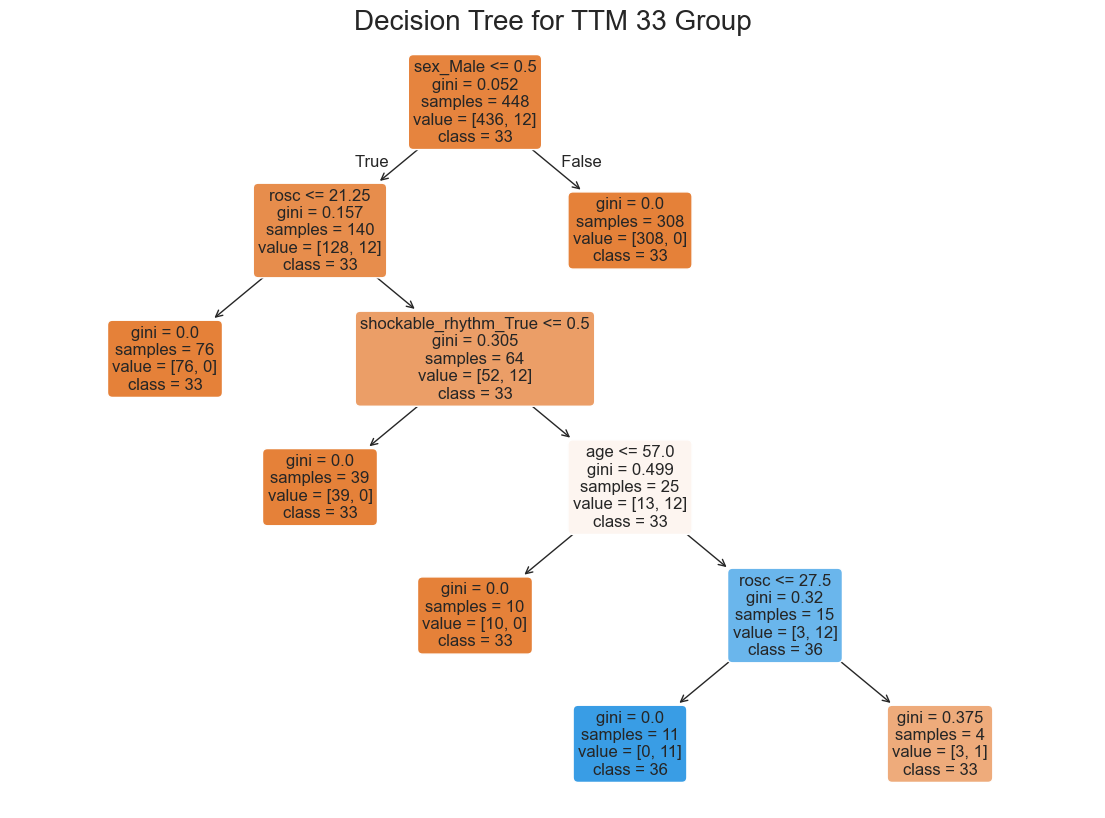


Decision Tree Rules for Group: TTM 36
|--- ohca_Unknown <= 0.50
|   |--- class: 36.0
|--- ohca_Unknown >  0.50
|   |--- age <= 72.00
|   |   |--- age <= 54.50
|   |   |   |--- age <= 50.00
|   |   |   |   |--- age <= 47.50
|   |   |   |   |   |--- class: 33
|   |   |   |   |--- age >  47.50
|   |   |   |   |   |--- class: 36.0
|   |   |   |--- age >  50.00
|   |   |   |   |--- class: 33
|   |   |--- age >  54.50
|   |   |   |--- sex_Female <= 0.50
|   |   |   |   |--- age <= 58.00
|   |   |   |   |   |--- class: 33
|   |   |   |   |--- age >  58.00
|   |   |   |   |   |--- class: 33
|   |   |   |--- sex_Female >  0.50
|   |   |   |   |--- class: 36.0
|   |--- age >  72.00
|   |   |--- class: 36.0

Saved decision tree for TTM 36 as SVG files.


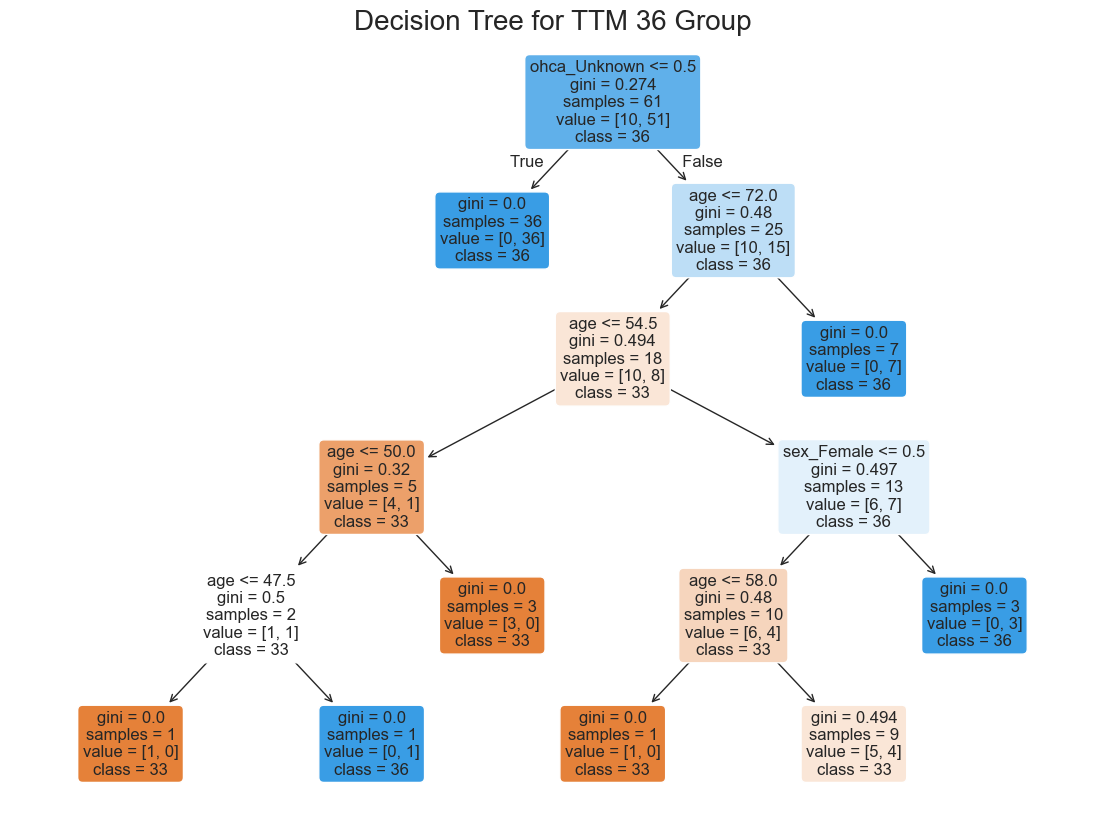


Decision Tree Rules for Group: No TTM
|--- age <= 37.50
|   |--- age <= 36.50
|   |   |--- class: No TTM
|   |--- age >  36.50
|   |   |--- rosc <= 29.00
|   |   |   |--- class: 33
|   |   |--- rosc >  29.00
|   |   |   |--- class: No TTM
|--- age >  37.50
|   |--- class: No TTM

Saved decision tree for No TTM as SVG files.


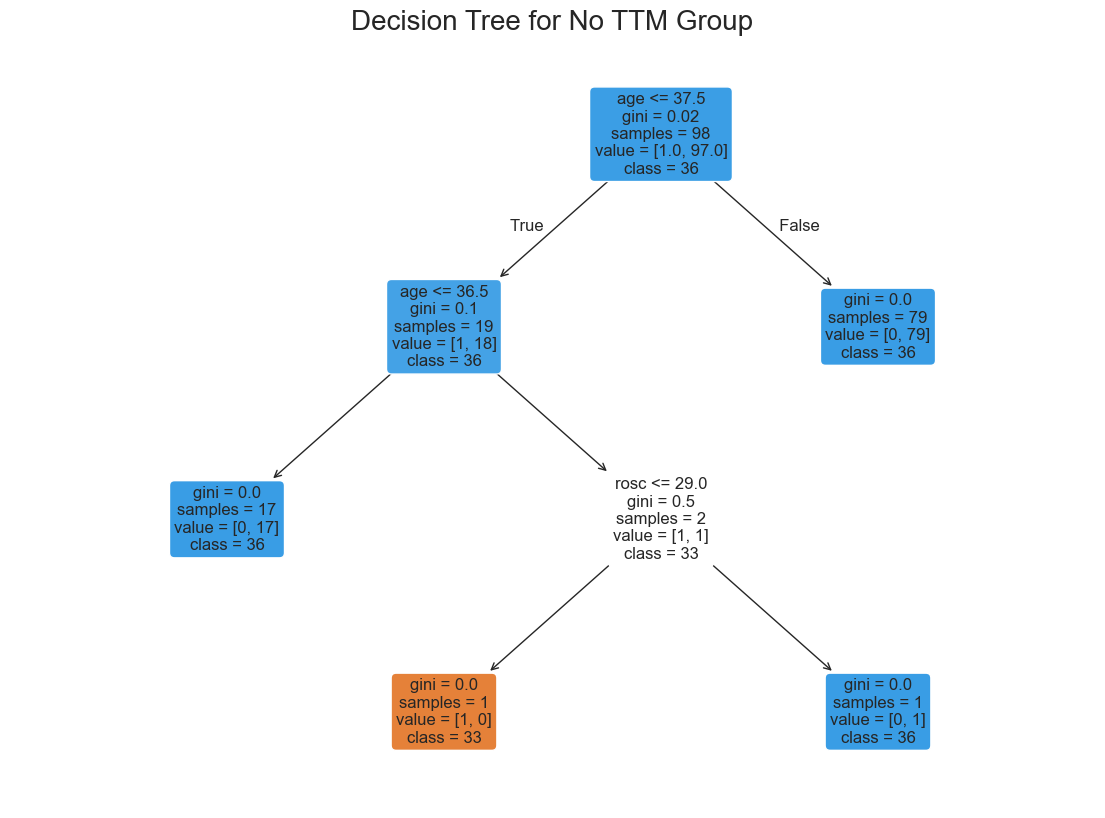

In [34]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex, to_rgb
import numpy as np

# Define font sizes
font_size = 20
axis_font_size = 18
legend_font_size = 16

# Dictionary of KI colors
KI_COLORS = {
    "ttm_33": "#870052",       # Plum for TTM 33
    "ttm_36": "#FF876F",       # Orange for TTM 36
    "ttm_no": "#4DB5BC",       # Blue for No TTM
}

# Define feature columns and target column
feature_columns = ['age', 'sex_Female', 'sex_Male', 'rosc', 'ohca_True', 'ohca_False', 'ohca_Unknown', 'shockable_rhythm_True', 'shockable_rhythm_False', 'shockable_rhythm_Unknown']
target_column = 'Best_Prediction_TTM'

# Loop through each TTM group and create a decision tree
for group_name, group_data in ttm_groups.items():
    print(f"\nDecision Tree Rules for Group: {group_name}")
    
    # Prepare features and target
    features = group_data[feature_columns]
    target = group_data[target_column]

    # Train a decision tree for the group
    tree = DecisionTreeClassifier(max_depth=5, random_state=42)
    tree.fit(features, target)

    # Display rules of the decision tree for the group
    print(export_text(tree, feature_names=feature_columns))

    # Visualize the decision tree
    fig, ax = plt.subplots(figsize=(14, 10))
    plot_tree(
        tree,
        feature_names=feature_columns,
        class_names=["33", "36", "No TTM"],  # Assuming TTM classes
        filled=True,
        rounded=True,
        fontsize=12,
        ax=ax
    )

    # Apply custom colors
    for idx, artist in enumerate(ax.findobj(match=lambda obj: hasattr(obj, "get_facecolor"))):
        node_value = tree.tree_.value[idx]
        if node_value[0].sum() == 0:  # Skip leaf nodes with no value
            continue
        # Choose color based on TTM class with a fade effect for impurity
        max_class_idx = np.argmax(node_value)
        color = (
            KI_COLORS["ttm_33"] if max_class_idx == 0 else
            KI_COLORS["ttm_36"] if max_class_idx == 1 else
            KI_COLORS["ttm_no"]
        )
        artist.set_facecolor(to_hex(color))

    plt.title(f"Decision Tree for {group_name} Group", fontsize=font_size)

    # Save the figure
    transparent_output_file = f"decision_tree_{group_name}_transparent.svg"
    white_output_file = f"decision_tree_{group_name}_white.svg"
    plt.savefig(transparent_output_file, format="svg", transparent=True)
    plt.savefig(white_output_file, format="svg", transparent=False)
    print(f"Saved decision tree for {group_name} as SVG files.")
    plt.show()
